## Семинар: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import math
import torch
import matplotlib
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

matplotlib.rcParams['animation.ffmpeg_path'] = r"D:\ffmpeg\bin\ffmpeg.exe"
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

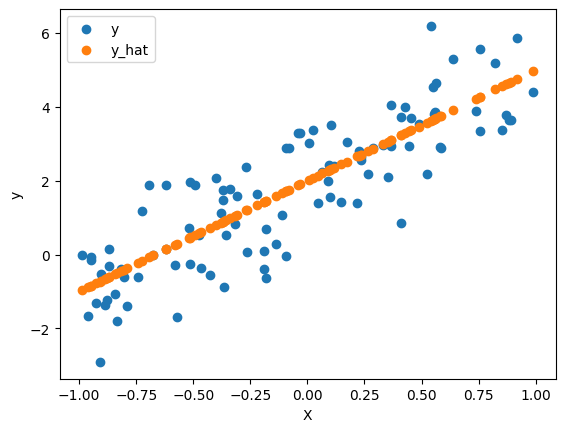

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

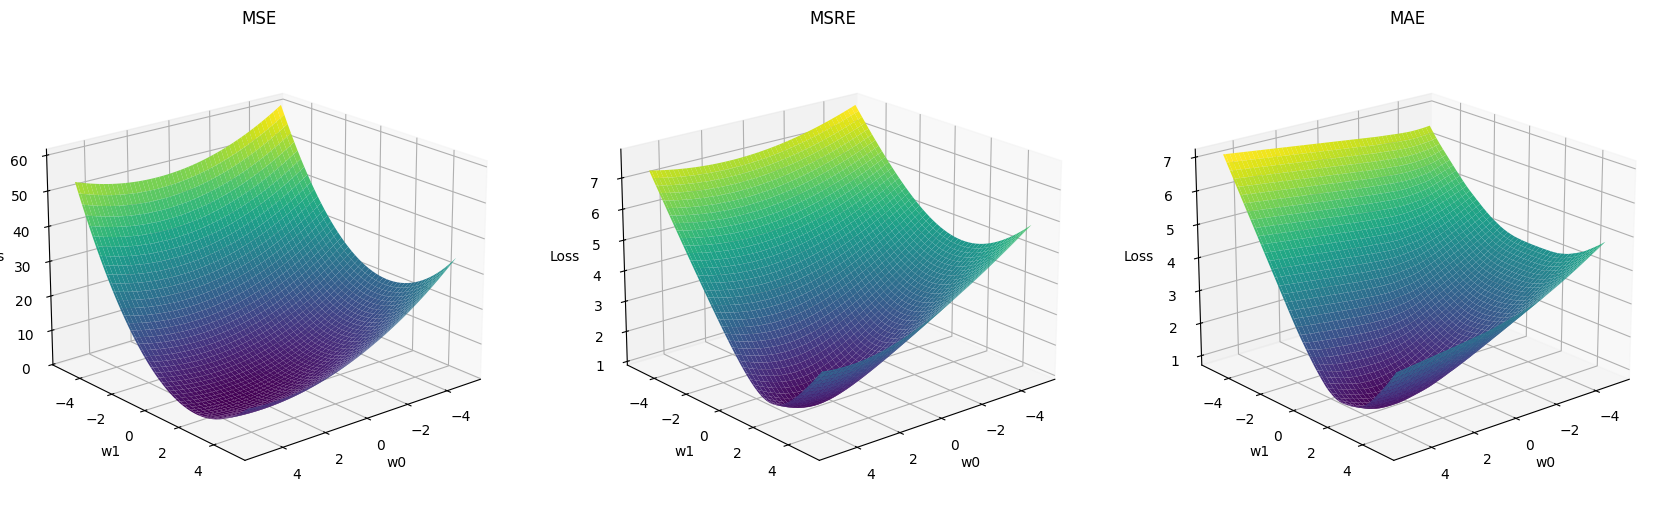

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.nu = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.nu * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [10]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [11]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [12]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [13]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [14]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [15]:
class Adam(Optimizer):
    def __init__(self, params, b1, b2, eta=1e-8, nu=1e-2):
        super().__init__(params)
        self.b1 = b1
        self.b2 = b2
        self.eta = eta
        self.nu = nu
        self.M = [torch.zeros(p.shape) for p in self.params]
        self.V = [torch.zeros(p.shape) for p in self.params]


    def step(self):
      with torch.no_grad():
        for i,p in enumerate(self.params):
          if p.grad is None:
            continue
          self.M[i] = self.b1 * self.M[i] + (1 - self.b1) * p.grad
          self.V[i] = self.b2 * self.V[i] + (1 - self.b2) * (p.grad**2)

          m_hat = self.M[i] / (1 - self.b1 ** (i+1))
          v_hat = self.V[i] / (1 - self.b2 ** (i+1))

          p -=(self.nu / (torch.sqrt(v_hat) + self.eta)) * m_hat

In [16]:
class AdamW(Optimizer):
    def __init__(self, params, b1=0.9, b2=0.999, eta=1e-8, nu=1e-3, weight_decay=0.01):
        super().__init__(params)
        self.b1 = b1
        self.b2 = b2
        self.eta = eta
        self.nu = nu
        self.weight_decay = weight_decay
        self.M = [torch.zeros(p.shape) for p in self.params]
        self.V = [torch.zeros(p.shape) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                    
                if self.weight_decay != 0:
                    p -= self.nu * self.weight_decay * p
                    
                g = p.grad
                self.M[i] = self.b1 * self.M[i] + (1 - self.b1) * g
                self.V[i] = self.b2 * self.V[i] + (1 - self.b2) * (g * g)
                
                m_hat = self.M[i] / (1 - self.b1 ** self.t)
                v_hat = self.V[i] / (1 - self.b2 ** self.t)

                p -= self.nu * m_hat / (torch.sqrt(v_hat) + self.eta)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        pad = 5 // 2

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 5, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 5, padding=pad),
            nn.ReLU()
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3136, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

In [18]:
# train с прошлого дз
def train(net, optimizer, train_loader, val_loader,
           epochs, criterion, scheduler=None, plot=True, verbose=True):
    train_loss_epochs, val_loss_epochs = [], []
    train_accuracy_epochs, val_accuracy_epochs = [], []

    n_params = 0
    for p in net.parameters():
        if p.requires_grad:
            n_params = n_params + p.numel()

    for epoch in tqdm(range(epochs)):
        losses = []
        correct = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            out = net(data)
            loss = criterion(out, target)
            losses.append(loss.item())

            pred = out.argmax(1)
            correct += pred.eq(target).sum().item()

            loss.backward()
            optimizer.step()

        train_loss = np.mean(losses)
        train_acc = correct / len(train_loader.dataset)
        train_loss_epochs.append(train_loss)
        train_accuracy_epochs.append(train_acc)

        losses = []
        correct = 0
        for data, target in val_loader:
            out = net(data)
            loss = criterion(out, target)
            losses.append(loss.item())

            pred = out.argmax(1)
            correct += pred.eq(target).sum().item()

        val_loss = np.mean(losses)
        val_acc = correct / len(val_loader.dataset)
        val_loss_epochs.append(val_loss)
        val_accuracy_epochs.append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if verbose:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train: loss={train_loss:.4f} | acc={train_acc:.4f}")
            print(f"  Val  : loss={val_loss:.4f} | acc={val_acc:.4f}")
            print(f"  Trainable params: {n_params}")
            print(f"  lr={scheduler.get_last_lr()[0] if scheduler else optimizer.nu:.6f}")

        if plot:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(val_loss_epochs, label='Val')
            plt.xlabel('Epochs'); plt.ylabel('Loss')
            plt.legend(); plt.grid(True)
            
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train')
            plt.plot(val_accuracy_epochs, label='Val')
            plt.xlabel('Epochs'); plt.ylabel('Accuracy')
            plt.legend(); plt.grid(True)
            plt.show()
    return {
        "train_loss": train_loss_epochs,
        "val_loss": val_loss_epochs,
        "train_acc": train_accuracy_epochs,
        "val_acc": val_accuracy_epochs,
    }

In [19]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

In [20]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [21]:
model = Net()
optimizer = Adam(params=model.parameters(), b1=0.9, b2=0.99, eta=1e-8, nu=0.005)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.1049 | acc=0.9682
  Val  : loss=0.0514 | acc=0.9851
  Trainable params: 34794
  lr=0.005000


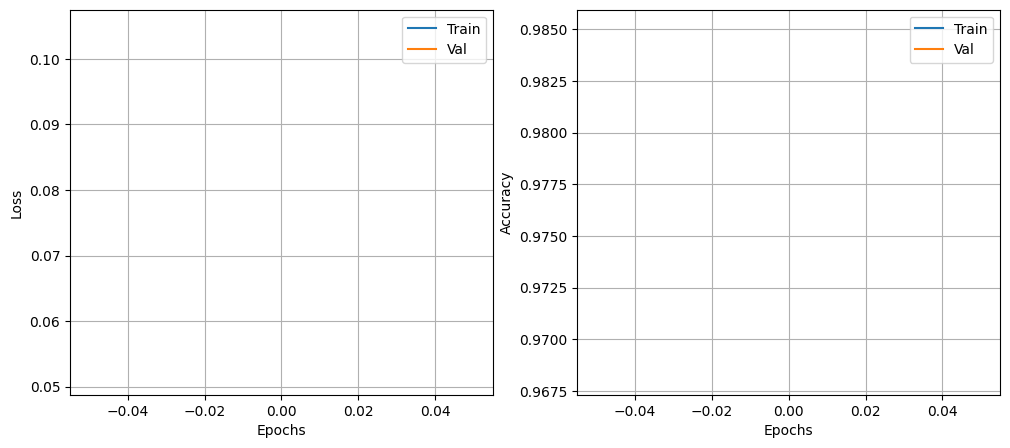

Epoch 2/10
  Train: loss=0.0519 | acc=0.9845
  Val  : loss=0.0388 | acc=0.9876
  Trainable params: 34794
  lr=0.005000


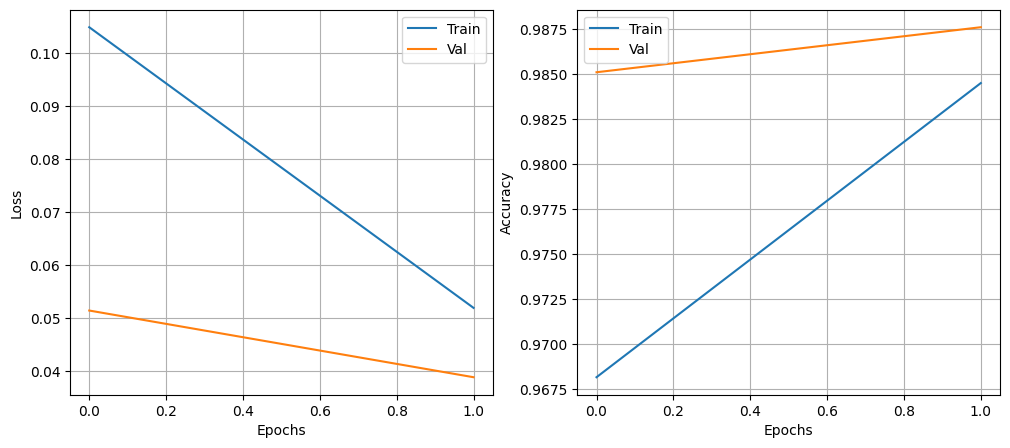

Epoch 3/10
  Train: loss=0.0411 | acc=0.9877
  Val  : loss=0.0440 | acc=0.9872
  Trainable params: 34794
  lr=0.005000


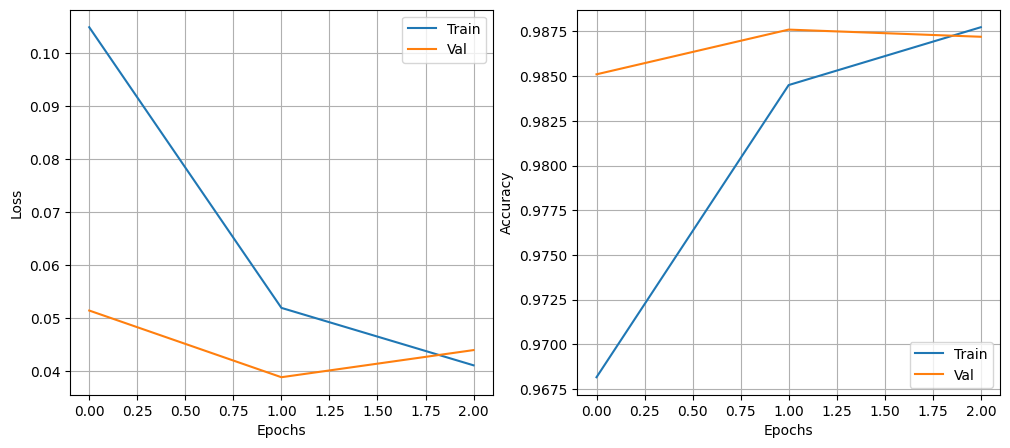

Epoch 4/10
  Train: loss=0.0365 | acc=0.9894
  Val  : loss=0.0415 | acc=0.9886
  Trainable params: 34794
  lr=0.005000


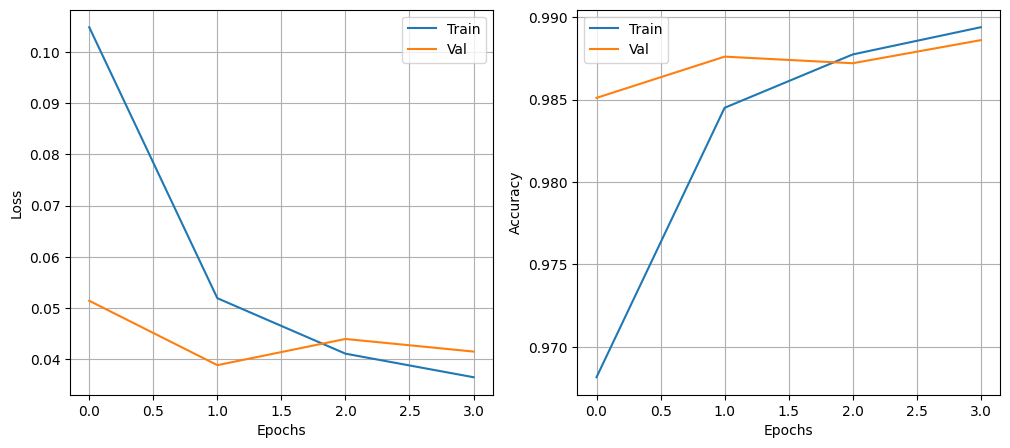

Epoch 5/10
  Train: loss=0.0322 | acc=0.9909
  Val  : loss=0.0471 | acc=0.9870
  Trainable params: 34794
  lr=0.005000


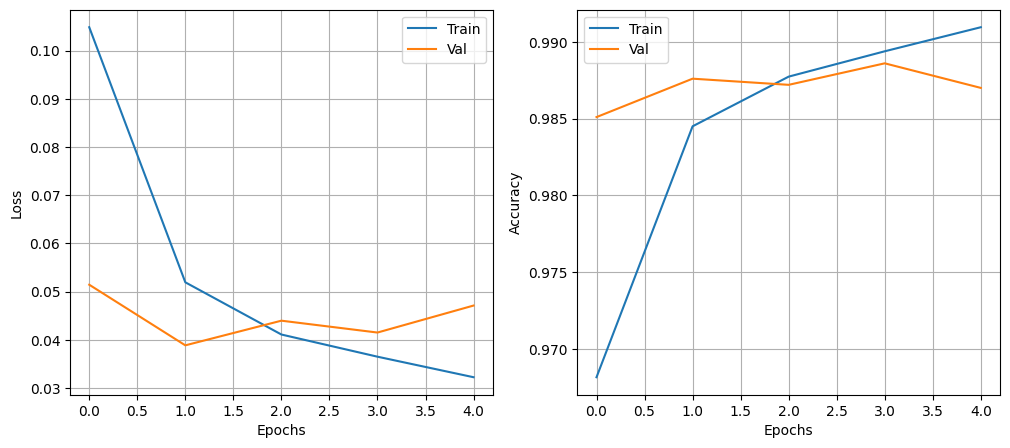

Epoch 6/10
  Train: loss=0.0286 | acc=0.9920
  Val  : loss=0.0497 | acc=0.9888
  Trainable params: 34794
  lr=0.005000


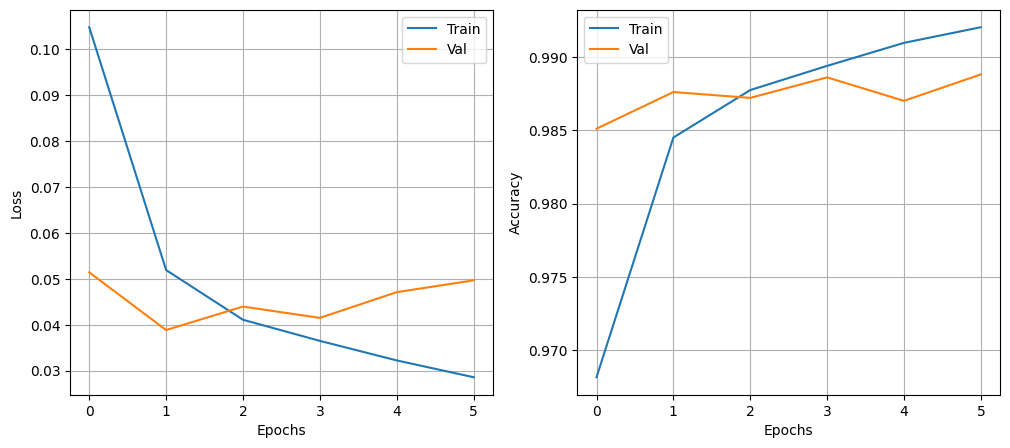

Epoch 7/10
  Train: loss=0.0270 | acc=0.9928
  Val  : loss=0.0815 | acc=0.9830
  Trainable params: 34794
  lr=0.005000


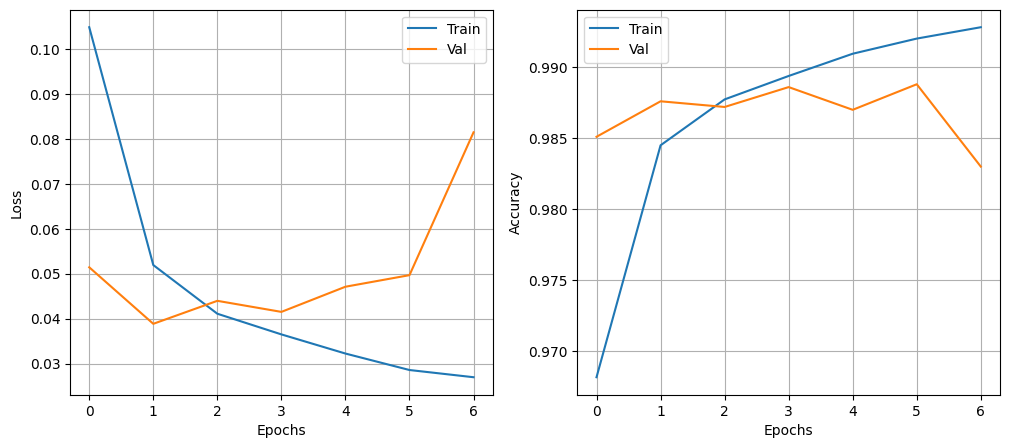

Epoch 8/10
  Train: loss=0.0246 | acc=0.9940
  Val  : loss=0.0835 | acc=0.9847
  Trainable params: 34794
  lr=0.005000


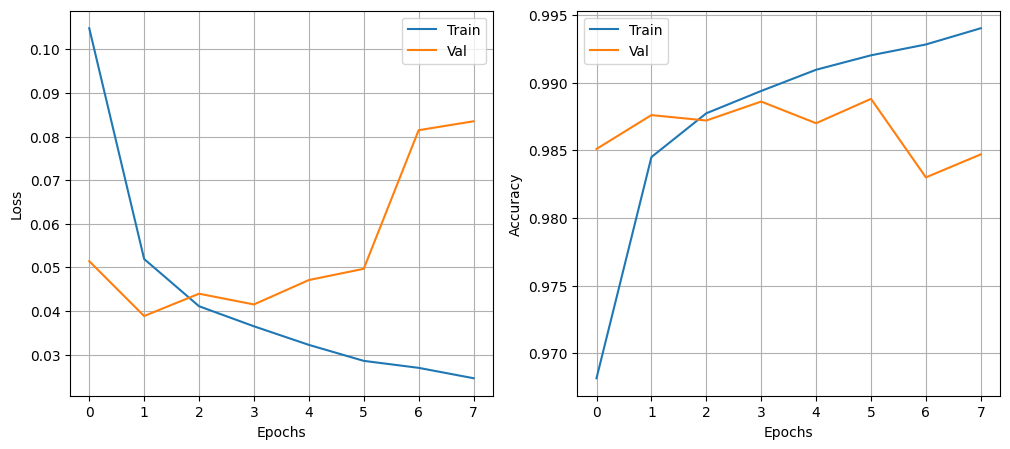

Epoch 9/10
  Train: loss=0.0243 | acc=0.9940
  Val  : loss=0.0729 | acc=0.9870
  Trainable params: 34794
  lr=0.005000


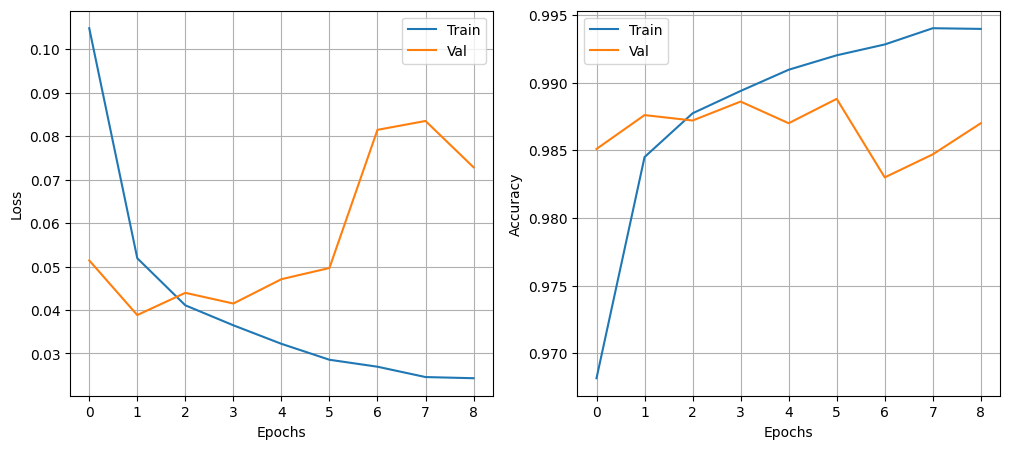

Epoch 10/10
  Train: loss=0.0250 | acc=0.9947
  Val  : loss=0.1126 | acc=0.9852
  Trainable params: 34794
  lr=0.005000


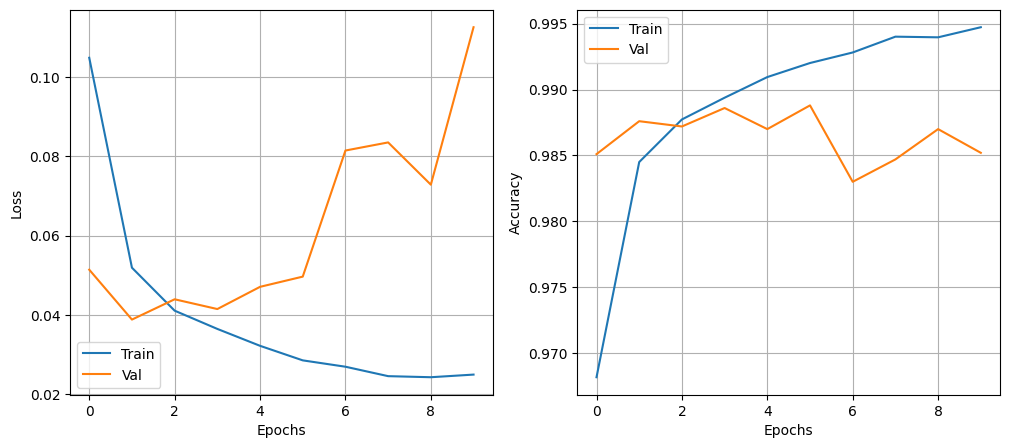

In [22]:
adam_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [23]:
model = Net()
optimizer = AdamW(params=model.parameters(), b1=0.9, b2=0.999, eta=1e-8, nu=0.005, weight_decay=0.01)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.1174 | acc=0.9653
  Val  : loss=0.0575 | acc=0.9819
  Trainable params: 34794
  lr=0.005000


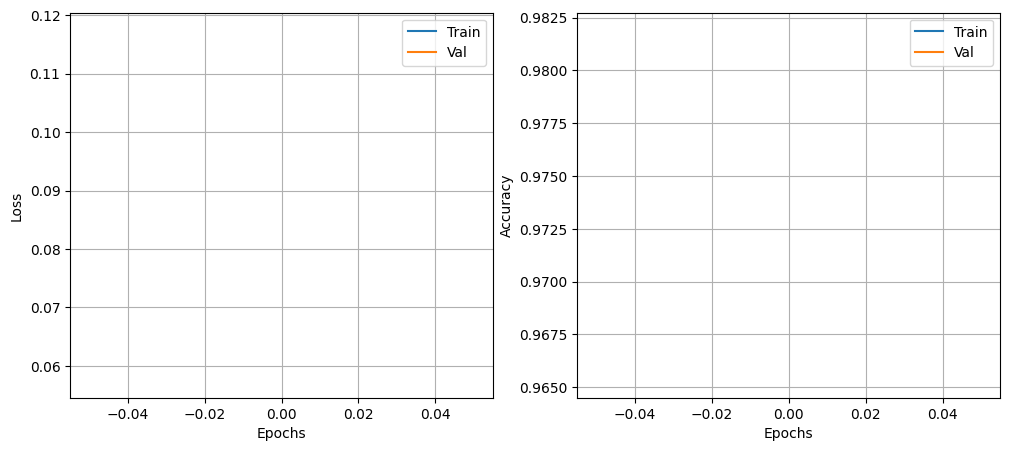

Epoch 2/10
  Train: loss=0.0612 | acc=0.9819
  Val  : loss=0.0560 | acc=0.9848
  Trainable params: 34794
  lr=0.005000


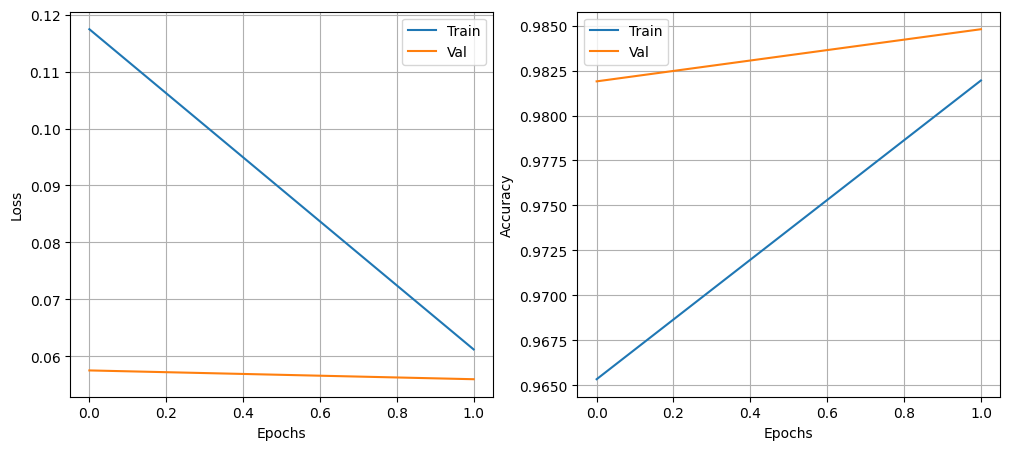

Epoch 3/10
  Train: loss=0.0538 | acc=0.9836
  Val  : loss=0.0602 | acc=0.9817
  Trainable params: 34794
  lr=0.005000


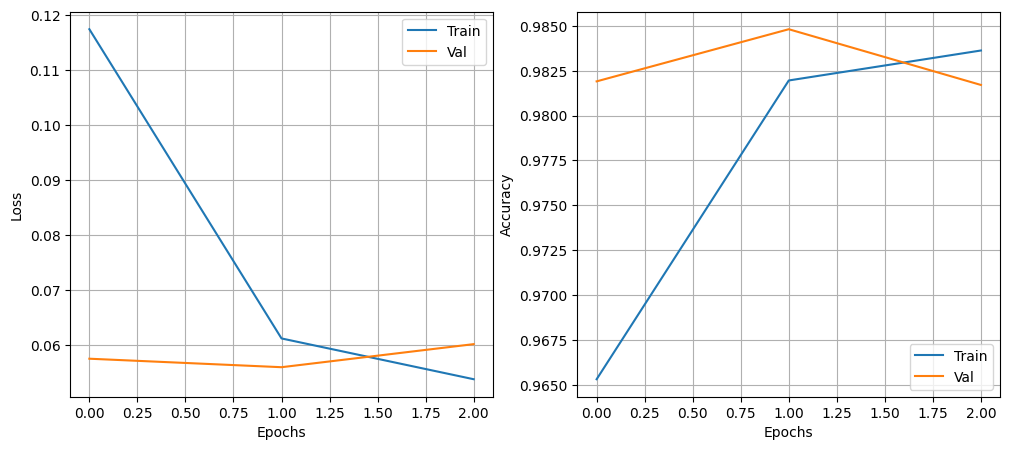

Epoch 4/10
  Train: loss=0.0490 | acc=0.9853
  Val  : loss=0.0460 | acc=0.9875
  Trainable params: 34794
  lr=0.005000


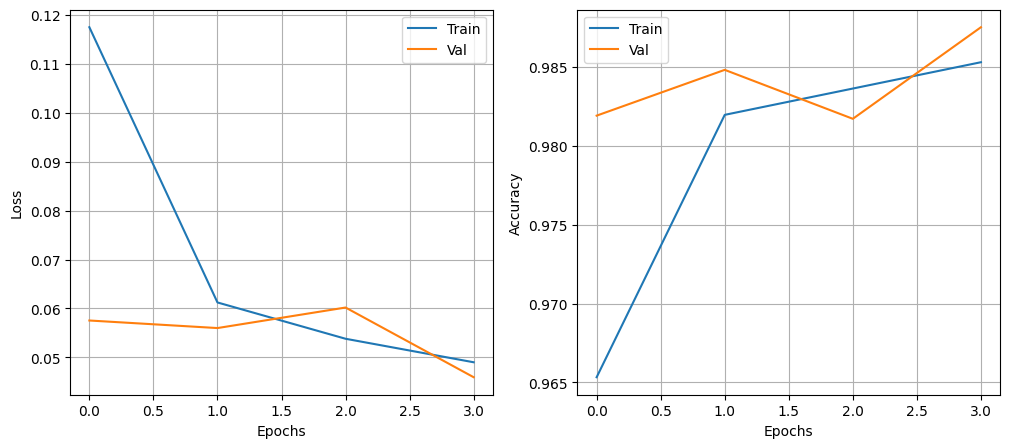

Epoch 5/10
  Train: loss=0.0457 | acc=0.9861
  Val  : loss=0.0672 | acc=0.9814
  Trainable params: 34794
  lr=0.005000


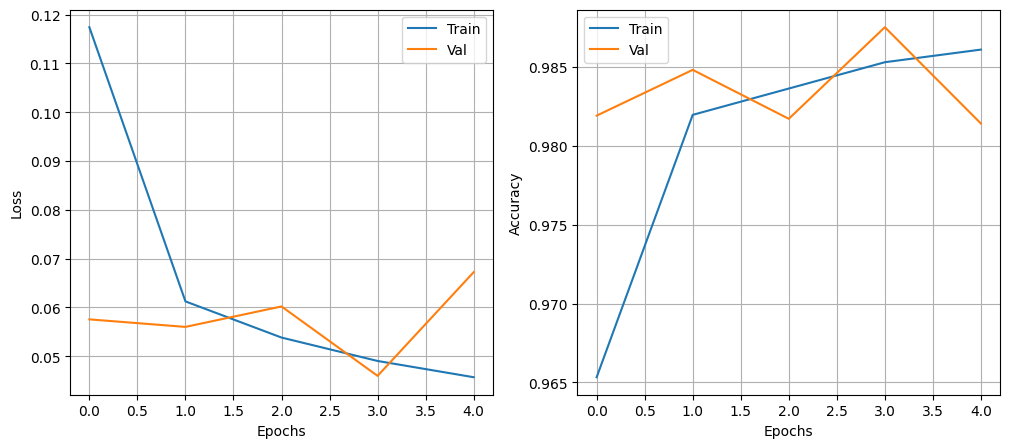

Epoch 6/10
  Train: loss=0.0416 | acc=0.9876
  Val  : loss=0.0608 | acc=0.9831
  Trainable params: 34794
  lr=0.005000


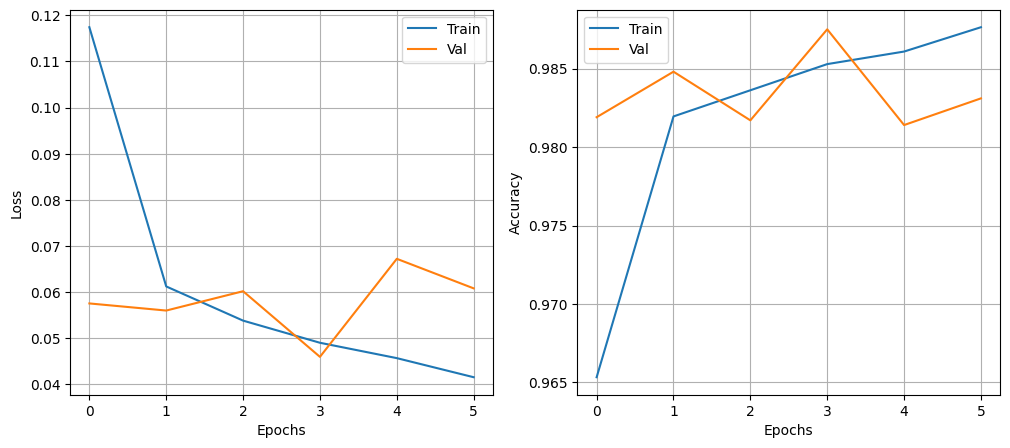

Epoch 7/10
  Train: loss=0.0402 | acc=0.9881
  Val  : loss=0.0558 | acc=0.9843
  Trainable params: 34794
  lr=0.005000


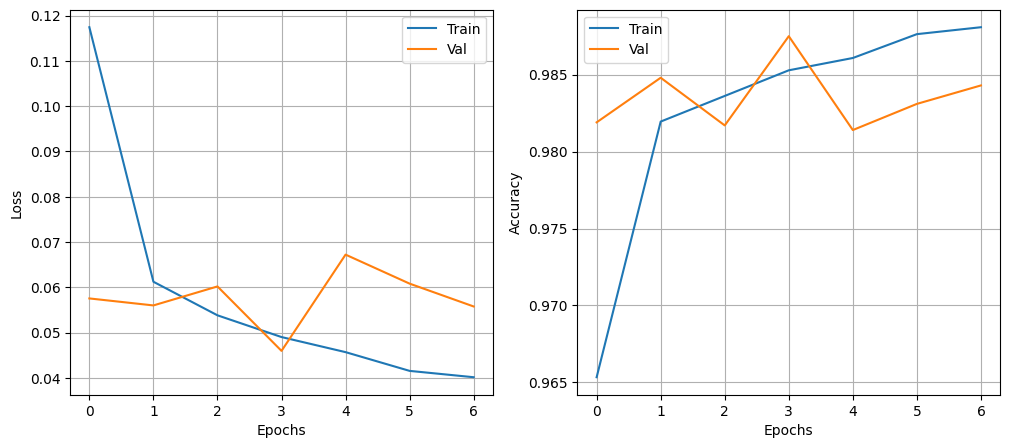

Epoch 8/10
  Train: loss=0.0376 | acc=0.9892
  Val  : loss=0.0724 | acc=0.9799
  Trainable params: 34794
  lr=0.005000


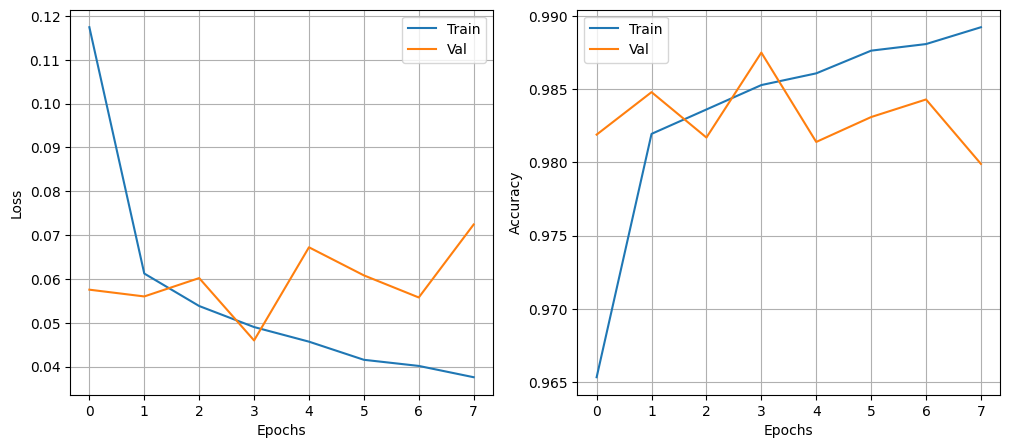

Epoch 9/10
  Train: loss=0.0372 | acc=0.9892
  Val  : loss=0.0707 | acc=0.9804
  Trainable params: 34794
  lr=0.005000


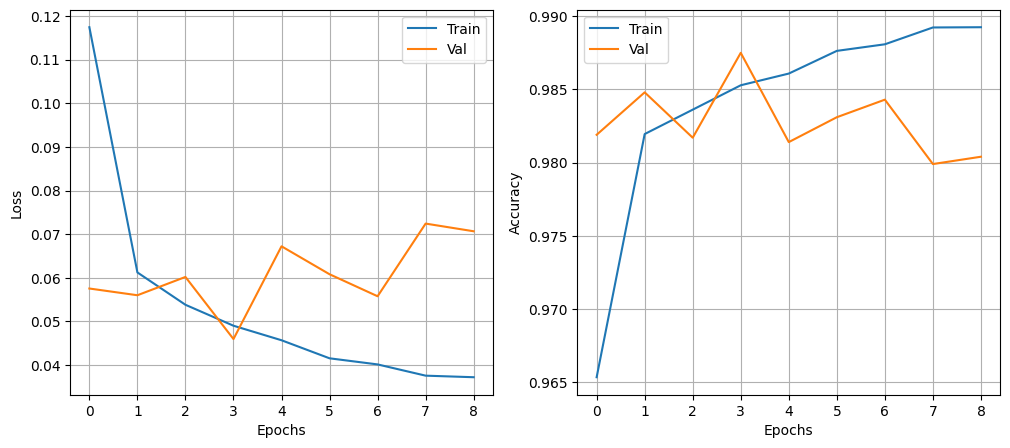

Epoch 10/10
  Train: loss=0.0363 | acc=0.9898
  Val  : loss=0.0923 | acc=0.9805
  Trainable params: 34794
  lr=0.005000


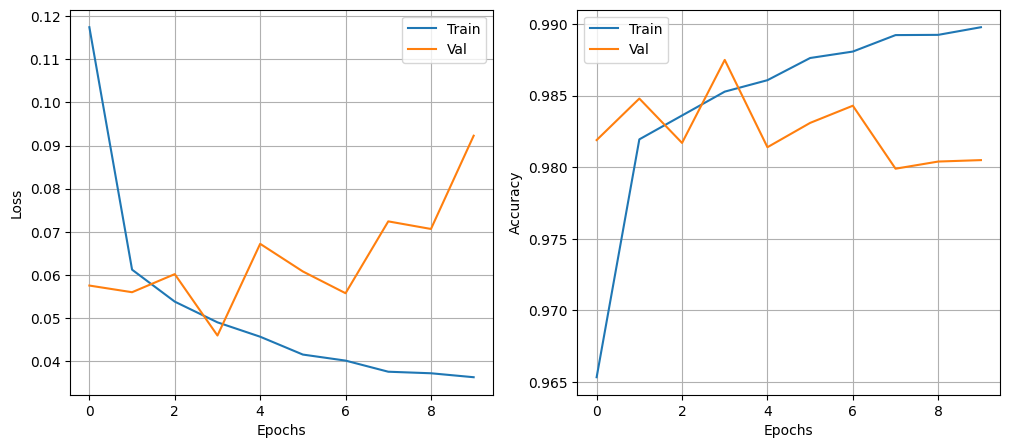

In [24]:
adamw_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [25]:
model = Net()
optimizer = SGD(params=model.parameters())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.2689 | acc=0.9214
  Val  : loss=0.0965 | acc=0.9717
  Trainable params: 34794
  lr=0.010000


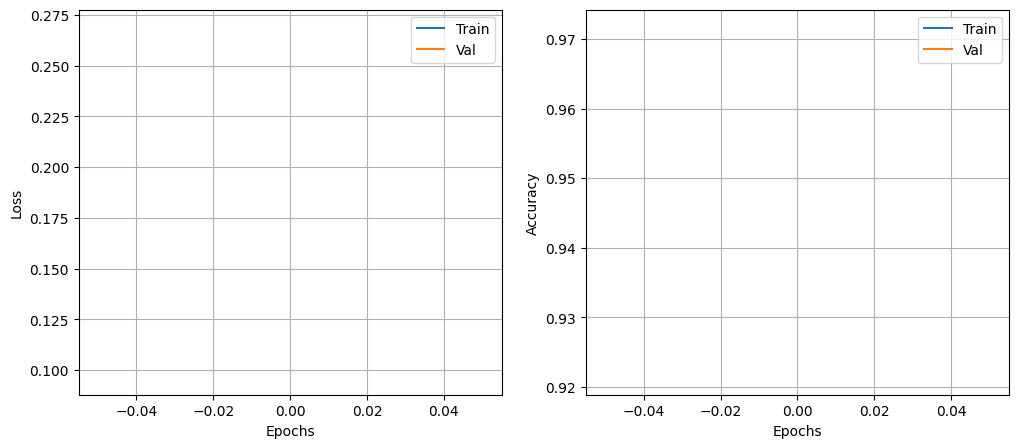

Epoch 2/10
  Train: loss=0.0904 | acc=0.9727
  Val  : loss=0.0626 | acc=0.9786
  Trainable params: 34794
  lr=0.010000


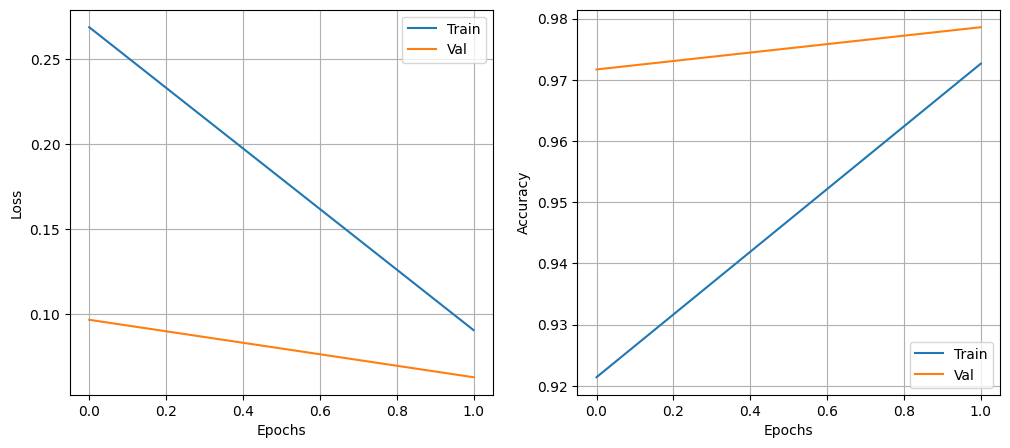

Epoch 3/10
  Train: loss=0.0676 | acc=0.9797
  Val  : loss=0.0531 | acc=0.9812
  Trainable params: 34794
  lr=0.010000


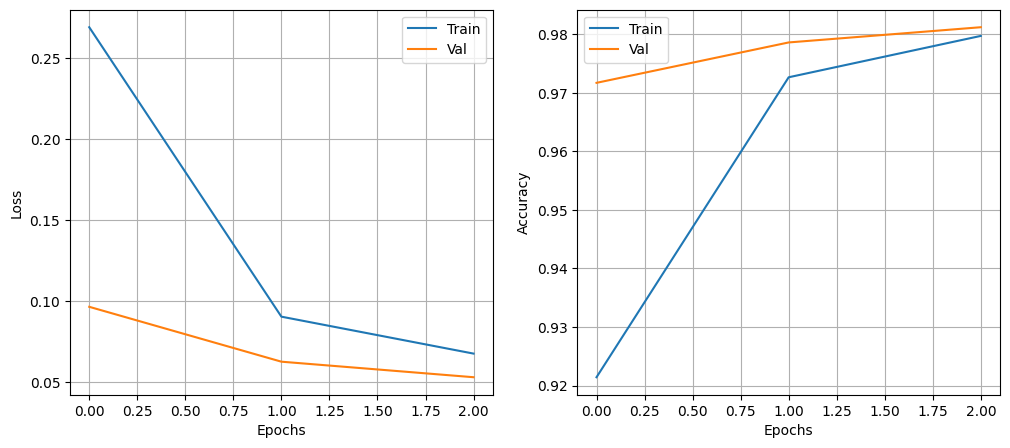

Epoch 4/10
  Train: loss=0.0553 | acc=0.9830
  Val  : loss=0.0469 | acc=0.9831
  Trainable params: 34794
  lr=0.010000


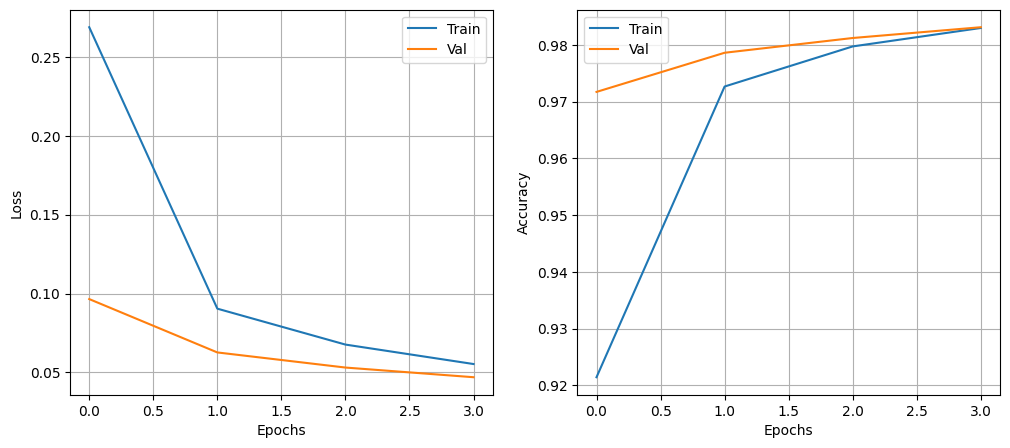

Epoch 5/10
  Train: loss=0.0476 | acc=0.9851
  Val  : loss=0.0426 | acc=0.9862
  Trainable params: 34794
  lr=0.010000


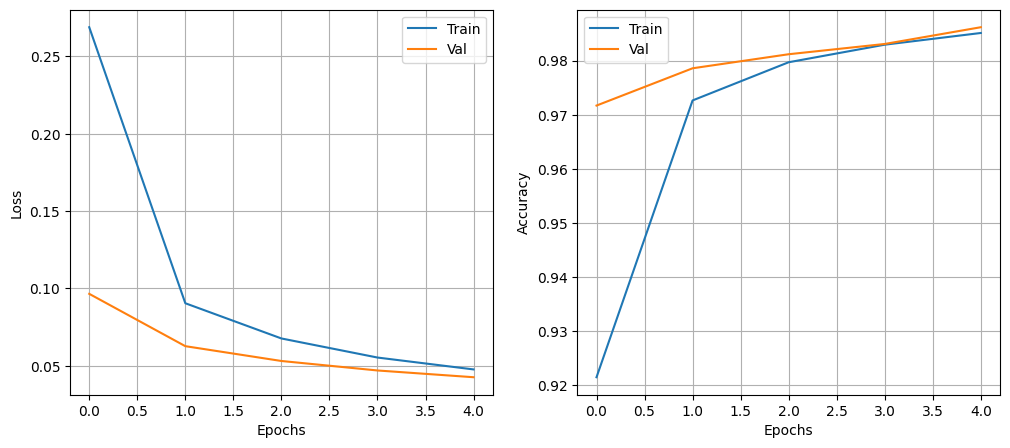

Epoch 6/10
  Train: loss=0.0422 | acc=0.9872
  Val  : loss=0.0467 | acc=0.9838
  Trainable params: 34794
  lr=0.010000


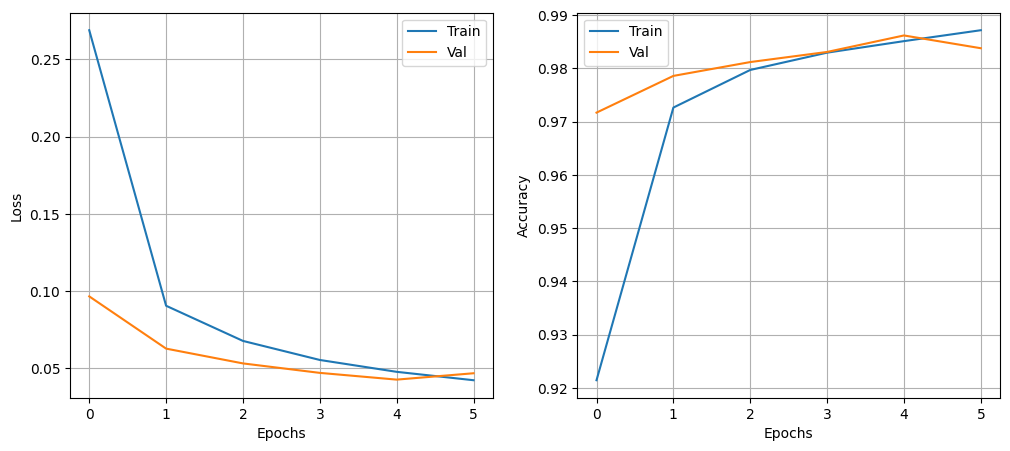

Epoch 7/10
  Train: loss=0.0371 | acc=0.9886
  Val  : loss=0.0414 | acc=0.9860
  Trainable params: 34794
  lr=0.010000


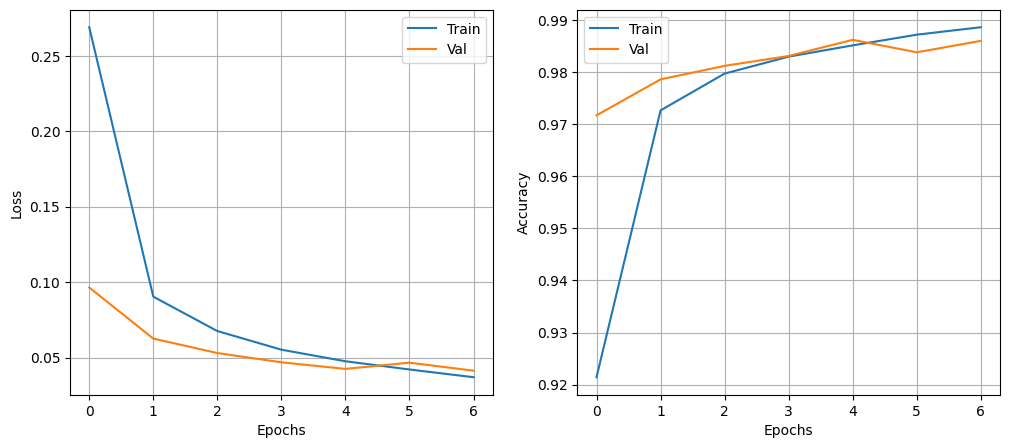

Epoch 8/10
  Train: loss=0.0338 | acc=0.9892
  Val  : loss=0.0377 | acc=0.9865
  Trainable params: 34794
  lr=0.010000


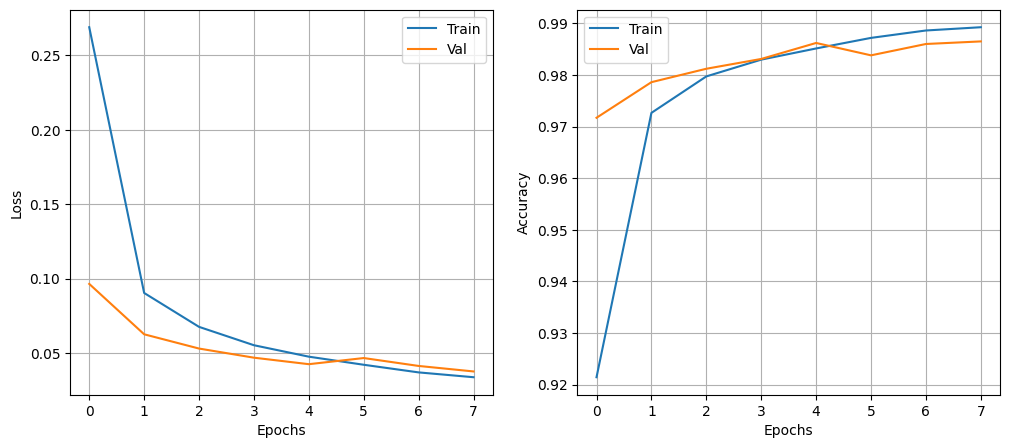

Epoch 9/10
  Train: loss=0.0311 | acc=0.9903
  Val  : loss=0.0341 | acc=0.9882
  Trainable params: 34794
  lr=0.010000


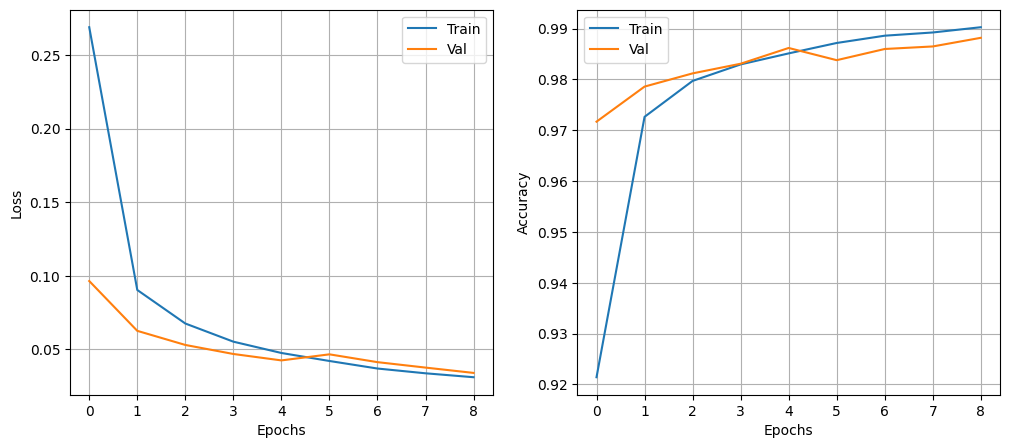

Epoch 10/10
  Train: loss=0.0283 | acc=0.9910
  Val  : loss=0.0378 | acc=0.9884
  Trainable params: 34794
  lr=0.010000


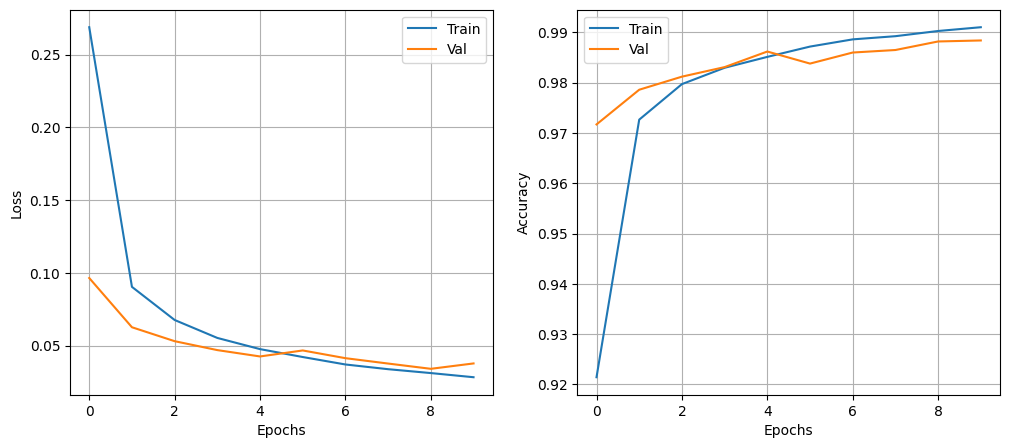

In [26]:
sgd_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

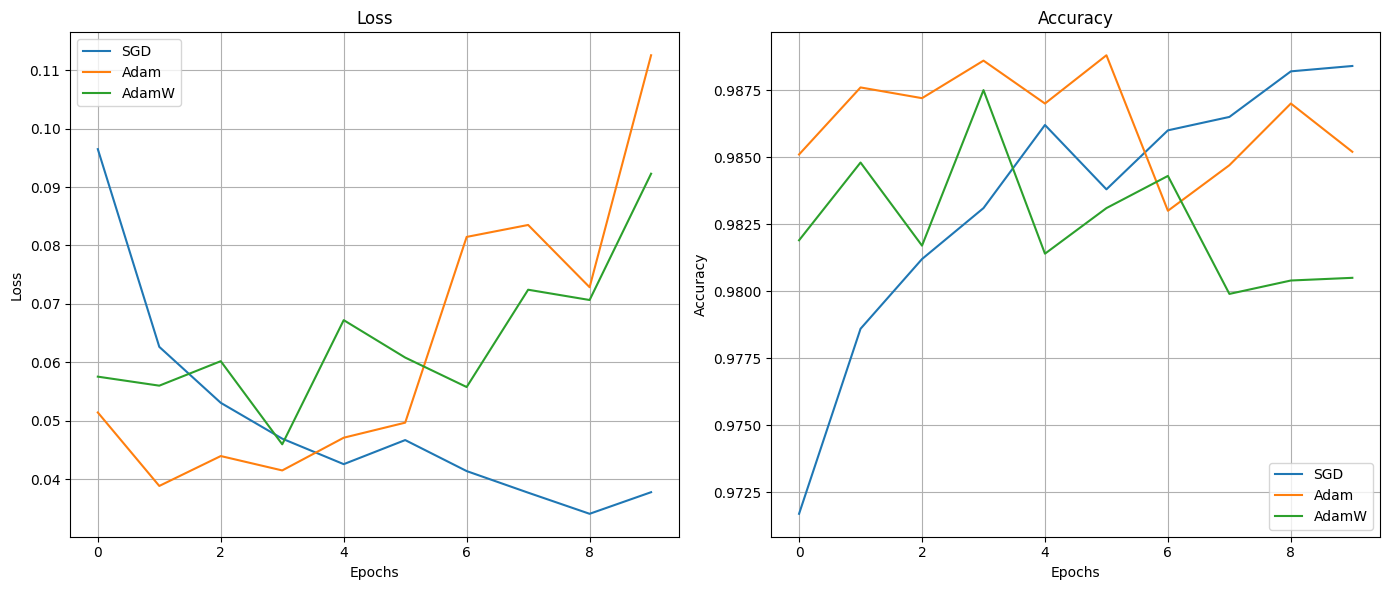

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(sgd_hist["val_loss"],  label="SGD")
ax1.plot(adam_hist["val_loss"], label="Adam")
ax1.plot(adamw_hist["val_loss"], label="AdamW")
ax1.set_title("Loss"); ax1.set_xlabel("Epochs"); ax1.set_ylabel("Loss"); ax1.legend(); ax1.grid(True)

ax2.plot(sgd_hist["val_acc"],  label="SGD")
ax2.plot(adam_hist["val_acc"], label="Adam")
ax2.plot(adamw_hist["val_acc"], label="AdamW")
ax2.set_title("Accuracy"); ax2.set_xlabel("Epochs"); ax2.set_ylabel("Accuracy"); ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.show()

Оптимизаторы Adam и AdamW сходятся быстрее, чем SGD, однако при этом демонстрируют менее стабильное поведение — особенно Adam, у которого loss начинает расти после нескольких эпох. SGD обучается медленнее, но показывает более плавное и устойчивое снижение ошибки и рост точности.

In [28]:
# согласно https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html

class LRScheduler:
    def __init__(self, optimizer: Optimizer, last_epoch: int = -1):
        self.optimizer = optimizer
        self.base_lr = float(optimizer.nu)
        self.last_lr = self.base_lr
        self.last_epoch = last_epoch

    def get_last_lr(self):
        return [self.last_lr]

    def step(self, epoch: int = None):
        if epoch is None:
            self.last_epoch += 1
        else:
            self.last_epoch = epoch
        self.optimizer.nu = self.base_lr
        self.last_lr = self.optimizer.nu

In [29]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100,
        last_epoch: int = -1
    ):
        super().__init__(optimizer, last_epoch)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters

    def step(self, epoch: int = None):
        if epoch is None:
            self.last_epoch += 1
        else:
            self.last_epoch = epoch

        if self.last_epoch < 0:
            factor = self.start_factor
        elif self.last_epoch <= self.total_iters:
            factor = self.start_factor + (self.end_factor - self.start_factor) * (self.last_epoch / self.total_iters)
        else:
            factor = self.end_factor

        self.optimizer.nu = self.base_lr * factor
        self.last_lr = self.optimizer.nu

class CosineAnnealing(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        T_max: int = 20,
        eta_min: float = 0.01,
        last_epoch: int = -1
    ):
        super().__init__(optimizer, last_epoch)
        self.T_max = T_max
        self.eta_min = eta_min

    def step(self, epoch: int = None):
        if epoch is None:
            self.last_epoch += 1
        else:
            self.last_epoch = epoch

        new_lr = self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (
            1 + math.cos(math.pi * self.last_epoch / self.T_max)
        )
        self.optimizer.nu = float(new_lr)
        self.last_lr = self.optimizer.nu

In [30]:
model = Net()
optimizer = Adam(params=model.parameters(), b1=0.9, b2=0.99, eta=1e-8, nu=0.005)
scheduler = LinearLR(optimizer, start_factor=0.2, end_factor=1.0, total_iters=5)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.1120 | acc=0.9668
  Val  : loss=0.0524 | acc=0.9818
  Trainable params: 34794
  lr=0.001000


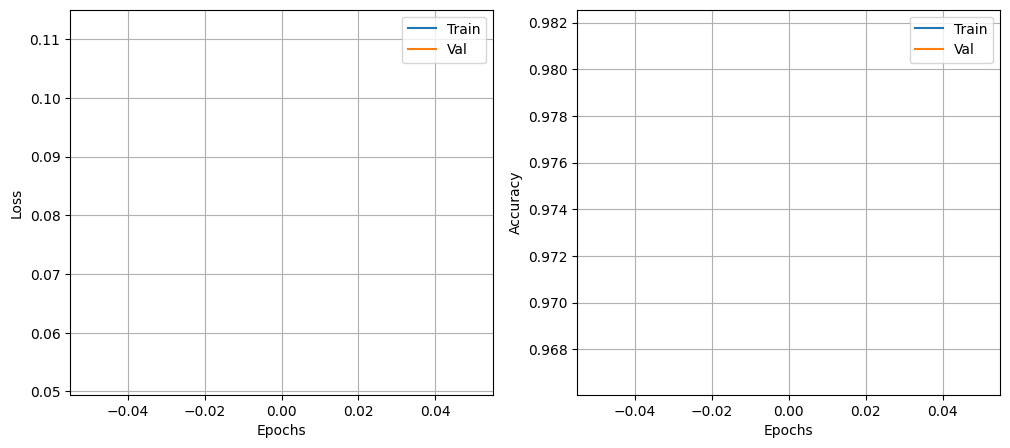

Epoch 2/10
  Train: loss=0.0319 | acc=0.9906
  Val  : loss=0.0315 | acc=0.9901
  Trainable params: 34794
  lr=0.001800


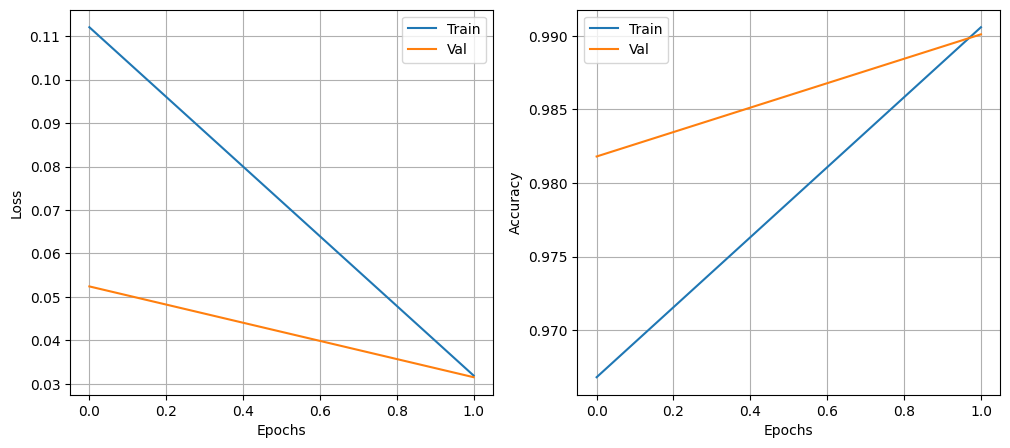

Epoch 3/10
  Train: loss=0.0284 | acc=0.9913
  Val  : loss=0.0330 | acc=0.9893
  Trainable params: 34794
  lr=0.002600


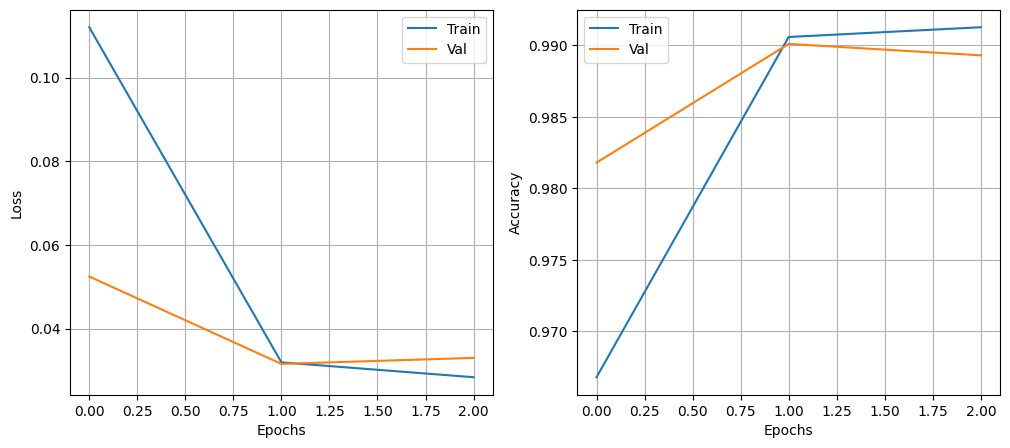

Epoch 4/10
  Train: loss=0.0273 | acc=0.9917
  Val  : loss=0.0392 | acc=0.9879
  Trainable params: 34794
  lr=0.003400


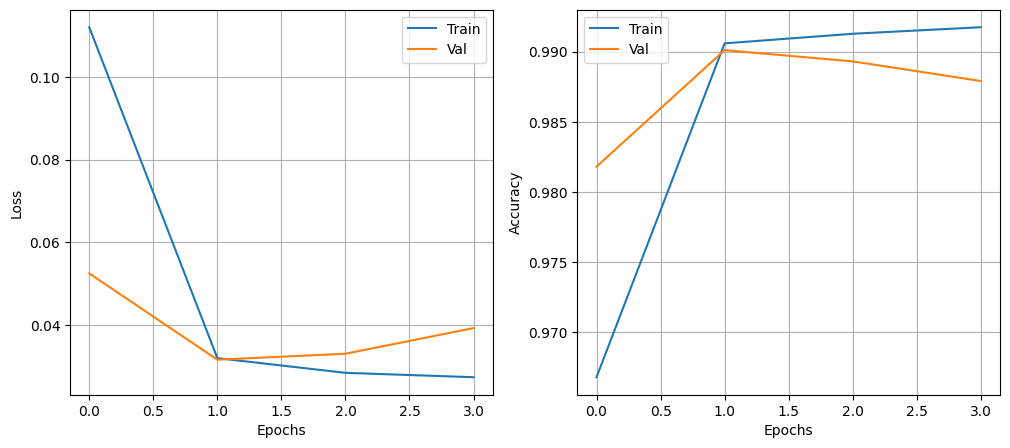

Epoch 5/10
  Train: loss=0.0277 | acc=0.9915
  Val  : loss=0.0532 | acc=0.9855
  Trainable params: 34794
  lr=0.004200


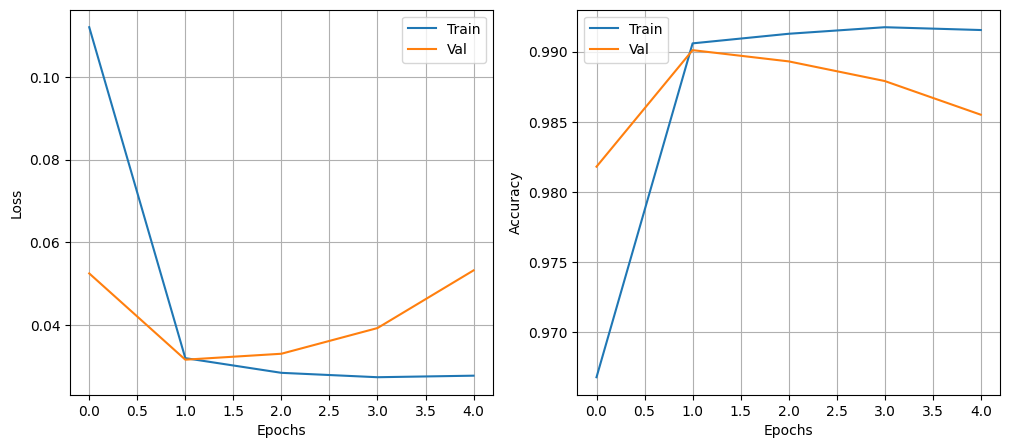

Epoch 6/10
  Train: loss=0.0310 | acc=0.9910
  Val  : loss=0.0547 | acc=0.9866
  Trainable params: 34794
  lr=0.005000


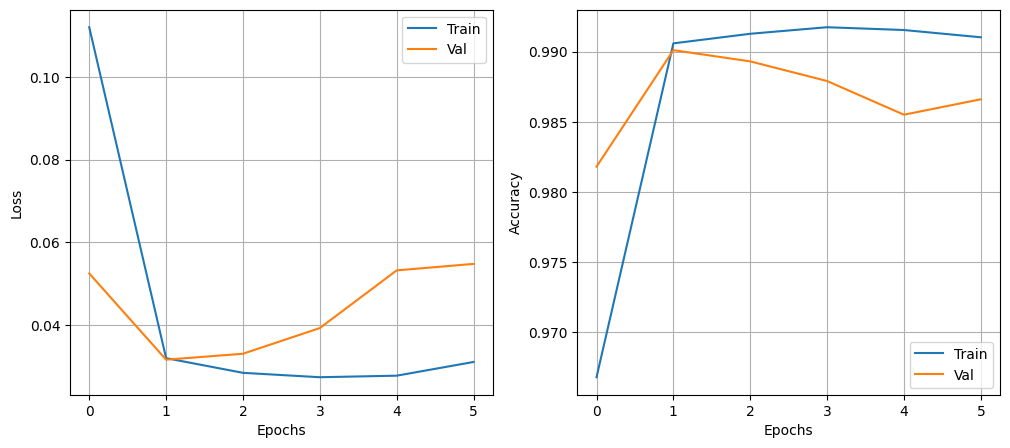

Epoch 7/10
  Train: loss=0.0355 | acc=0.9901
  Val  : loss=0.0712 | acc=0.9819
  Trainable params: 34794
  lr=0.005000


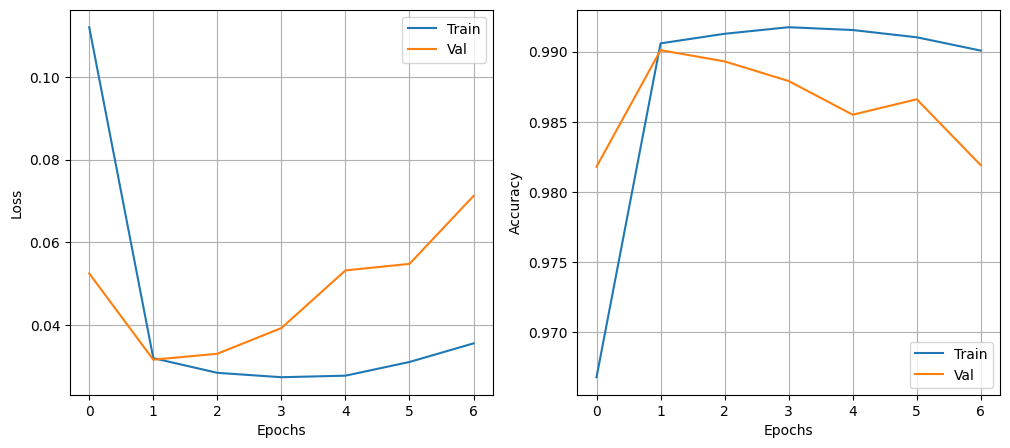

Epoch 8/10
  Train: loss=0.0316 | acc=0.9911
  Val  : loss=0.0773 | acc=0.9825
  Trainable params: 34794
  lr=0.005000


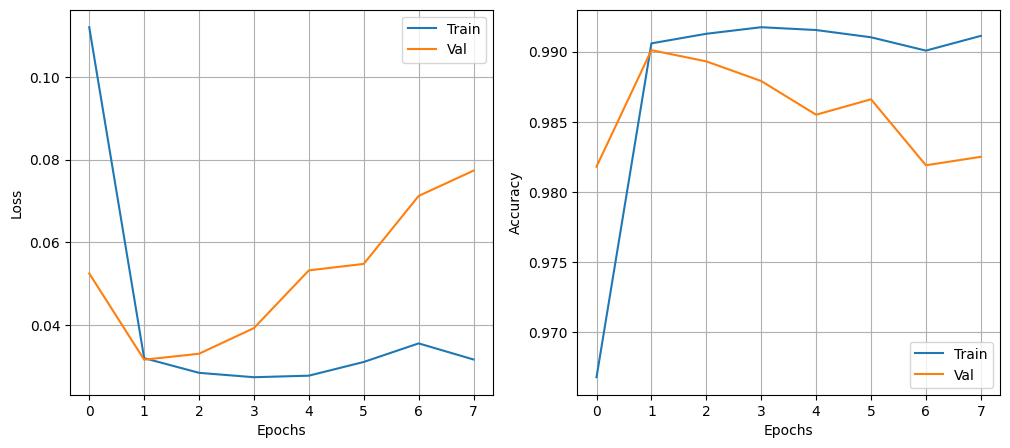

Epoch 9/10
  Train: loss=0.0310 | acc=0.9916
  Val  : loss=0.0811 | acc=0.9819
  Trainable params: 34794
  lr=0.005000


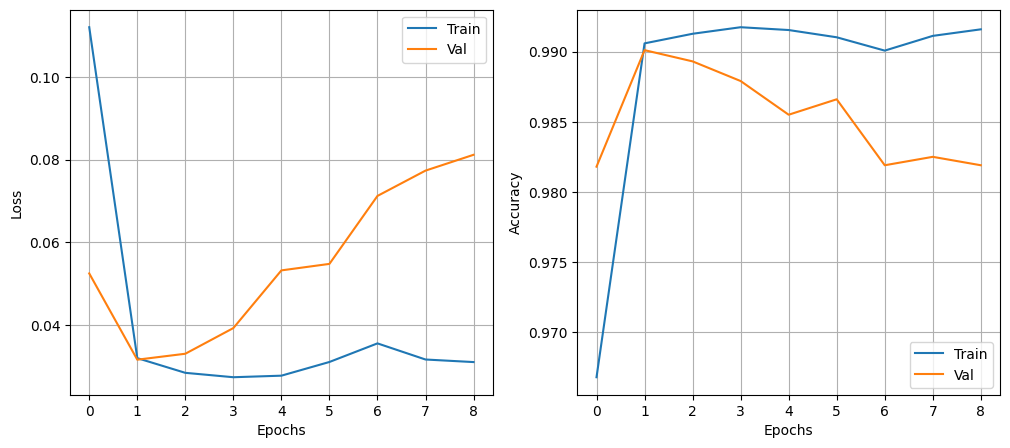

Epoch 10/10
  Train: loss=0.0299 | acc=0.9924
  Val  : loss=0.0801 | acc=0.9838
  Trainable params: 34794
  lr=0.005000


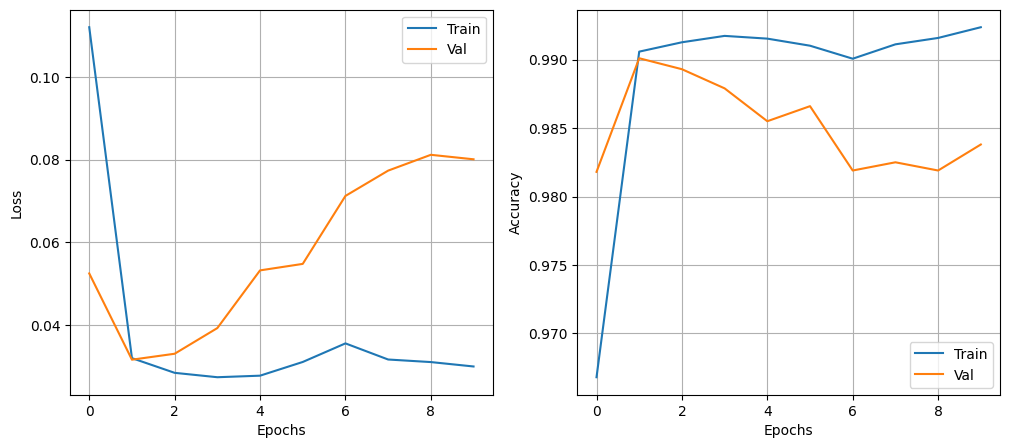

In [31]:
lin_adam_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       scheduler=scheduler,train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [32]:
model = Net()
optimizer = AdamW(params=model.parameters(), b1=0.9, b2=0.999, eta=1e-8, nu=0.005, weight_decay=0.01)
scheduler = LinearLR(optimizer, start_factor=0.2, end_factor=1.0, total_iters=5)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.1108 | acc=0.9666
  Val  : loss=0.0672 | acc=0.9792
  Trainable params: 34794
  lr=0.001000


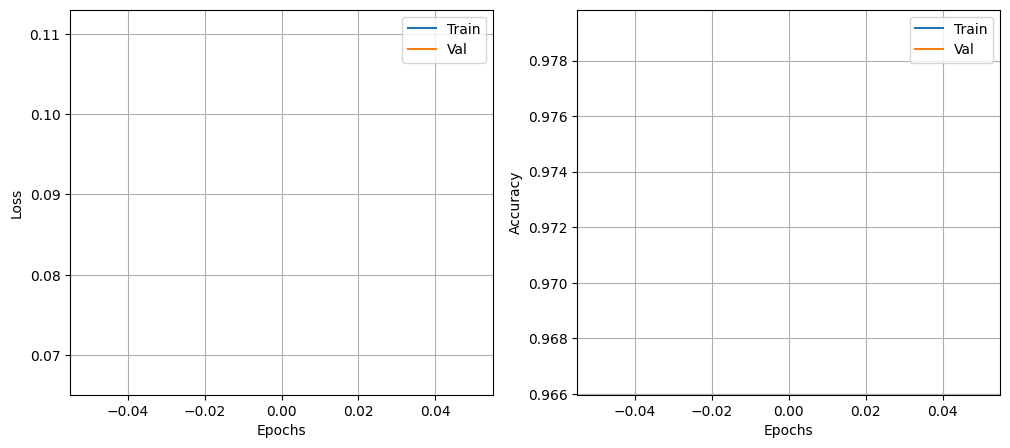

Epoch 2/10
  Train: loss=0.0303 | acc=0.9905
  Val  : loss=0.0285 | acc=0.9912
  Trainable params: 34794
  lr=0.001800


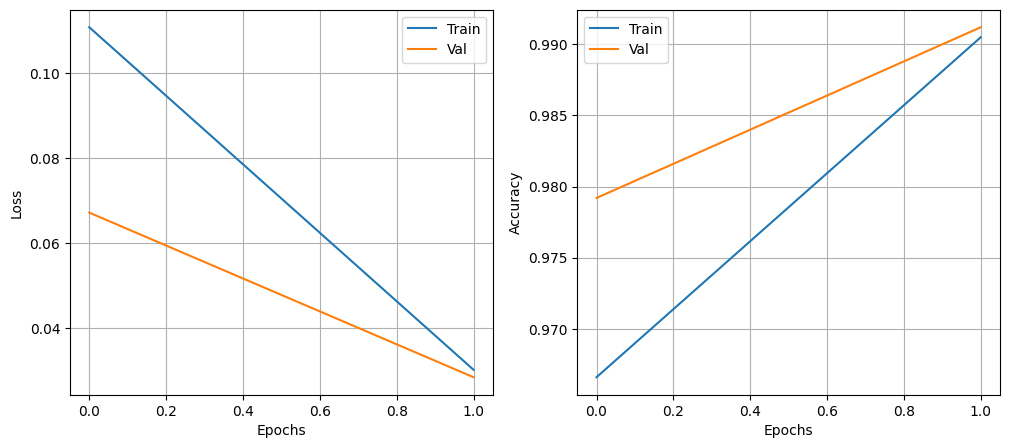

Epoch 3/10
  Train: loss=0.0281 | acc=0.9905
  Val  : loss=0.0303 | acc=0.9907
  Trainable params: 34794
  lr=0.002600


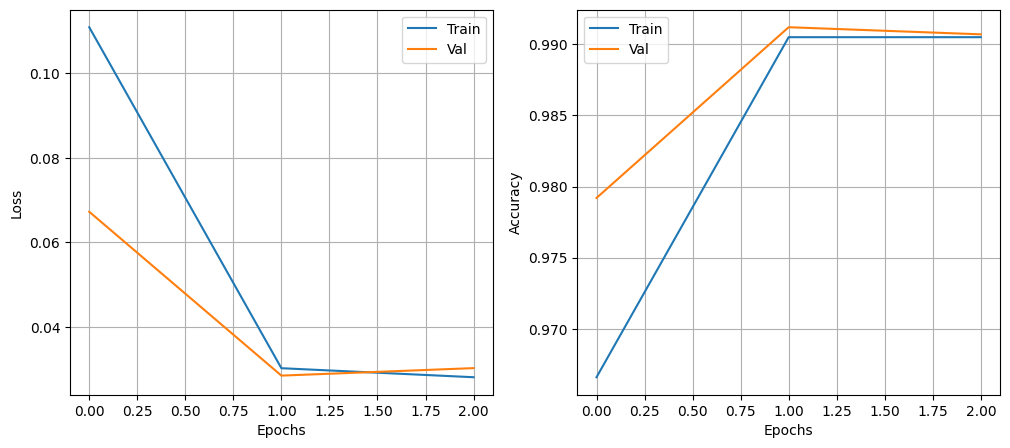

Epoch 4/10
  Train: loss=0.0295 | acc=0.9904
  Val  : loss=0.0428 | acc=0.9872
  Trainable params: 34794
  lr=0.003400


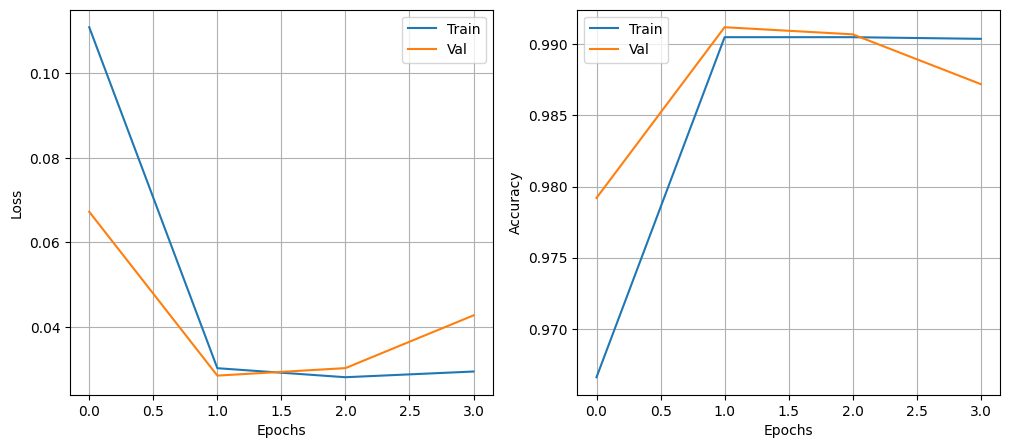

Epoch 5/10
  Train: loss=0.0357 | acc=0.9891
  Val  : loss=0.0500 | acc=0.9845
  Trainable params: 34794
  lr=0.004200


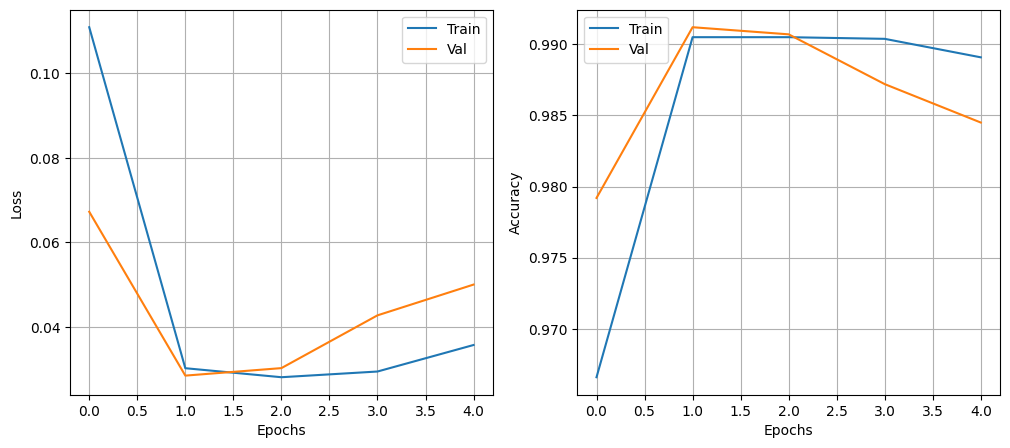

Epoch 6/10
  Train: loss=0.0393 | acc=0.9885
  Val  : loss=0.0732 | acc=0.9796
  Trainable params: 34794
  lr=0.005000


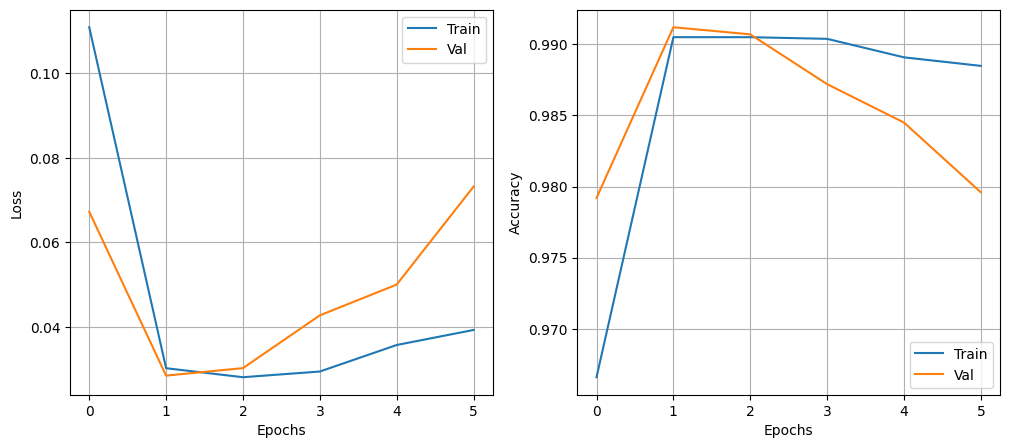

Epoch 7/10
  Train: loss=0.0472 | acc=0.9861
  Val  : loss=0.0563 | acc=0.9837
  Trainable params: 34794
  lr=0.005000


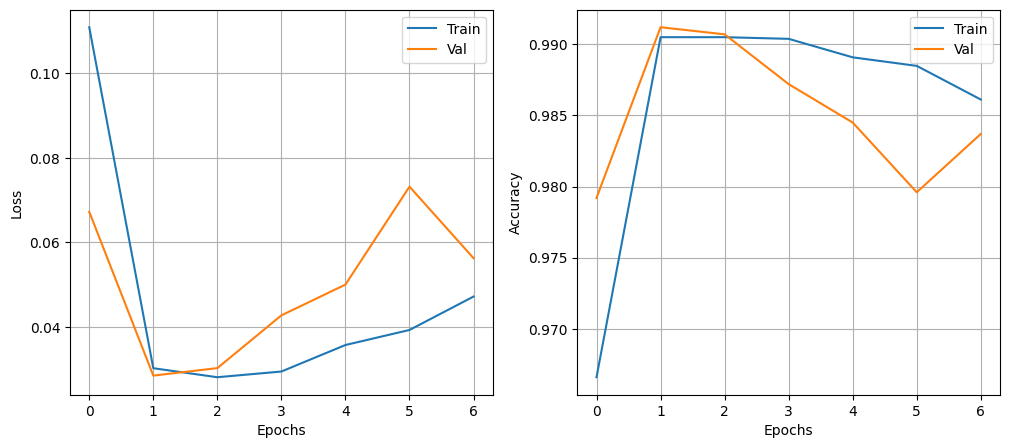

Epoch 8/10
  Train: loss=0.0433 | acc=0.9870
  Val  : loss=0.0763 | acc=0.9827
  Trainable params: 34794
  lr=0.005000


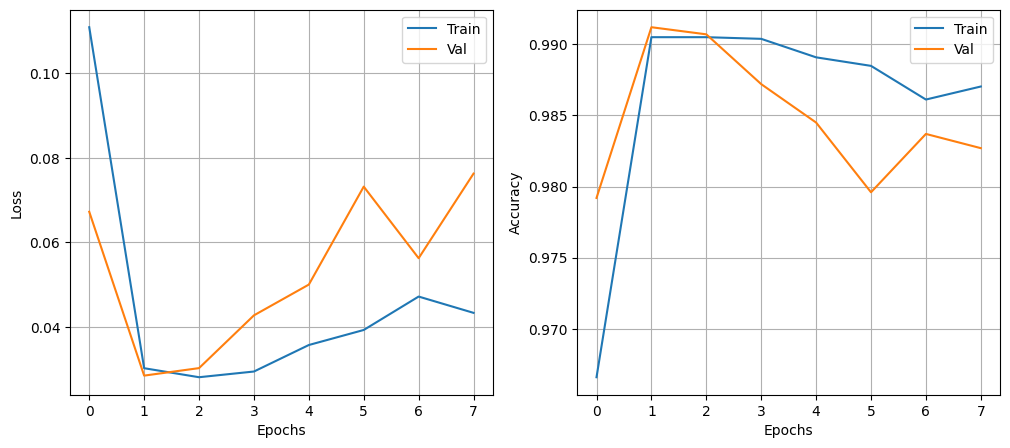

Epoch 9/10
  Train: loss=0.0420 | acc=0.9882
  Val  : loss=0.0631 | acc=0.9846
  Trainable params: 34794
  lr=0.005000


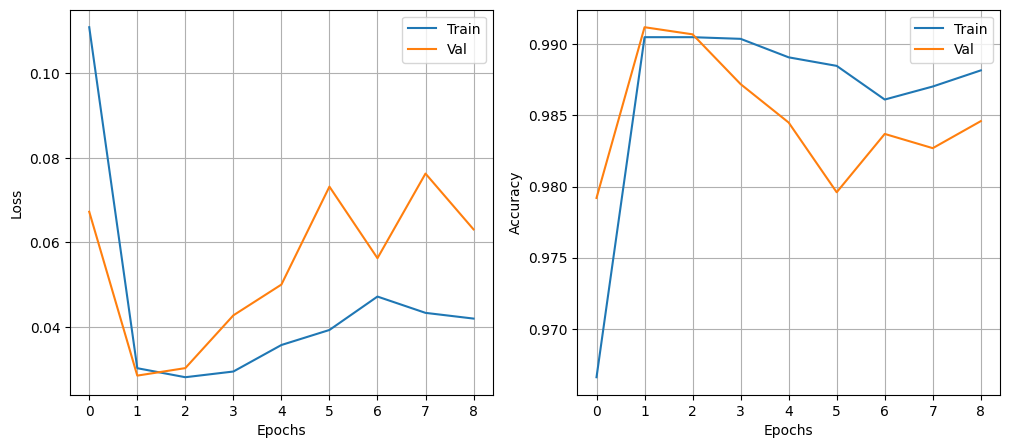

Epoch 10/10
  Train: loss=0.0413 | acc=0.9882
  Val  : loss=0.0586 | acc=0.9855
  Trainable params: 34794
  lr=0.005000


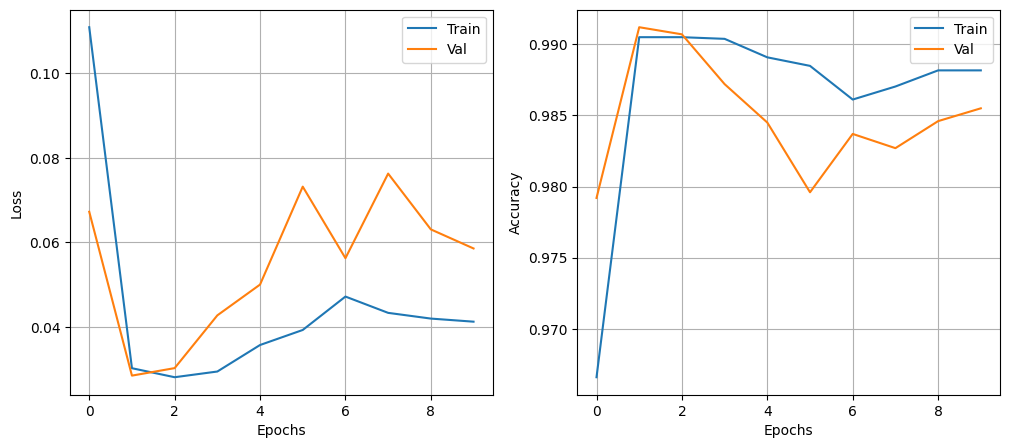

In [33]:
lin_adamw_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       scheduler=scheduler,train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [34]:
model = Net()
optimizer = SGD(params=model.parameters())
scheduler = LinearLR(optimizer, start_factor=0.2, end_factor=1.0, total_iters=5)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.2658 | acc=0.9212
  Val  : loss=0.0937 | acc=0.9709
  Trainable params: 34794
  lr=0.002000


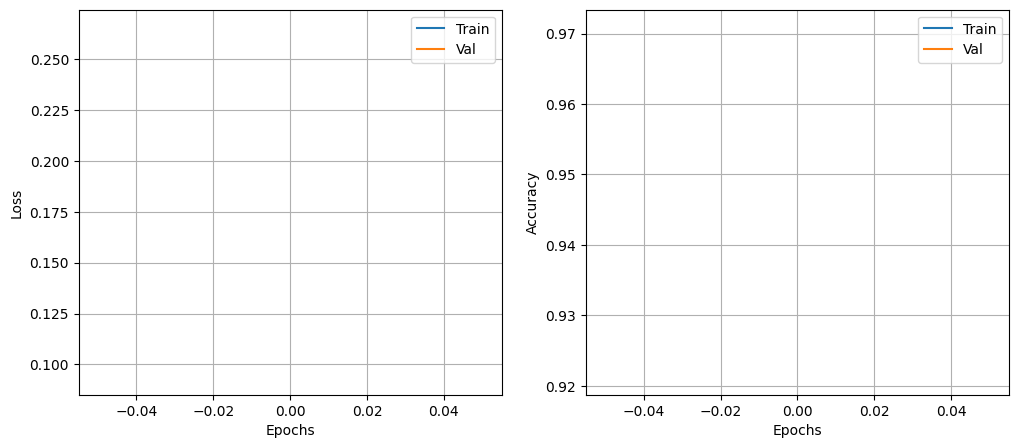

Epoch 2/10
  Train: loss=0.0919 | acc=0.9732
  Val  : loss=0.0782 | acc=0.9757
  Trainable params: 34794
  lr=0.003600


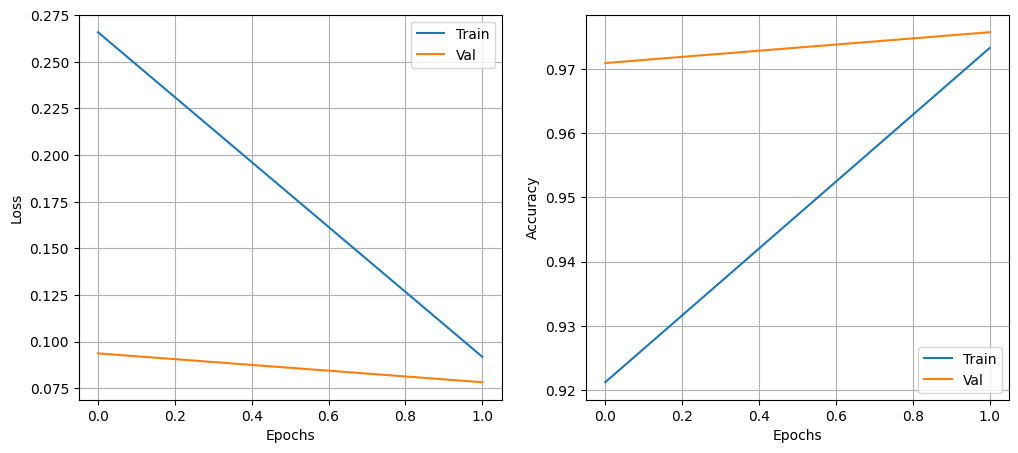

Epoch 3/10
  Train: loss=0.0814 | acc=0.9759
  Val  : loss=0.0672 | acc=0.9794
  Trainable params: 34794
  lr=0.005200


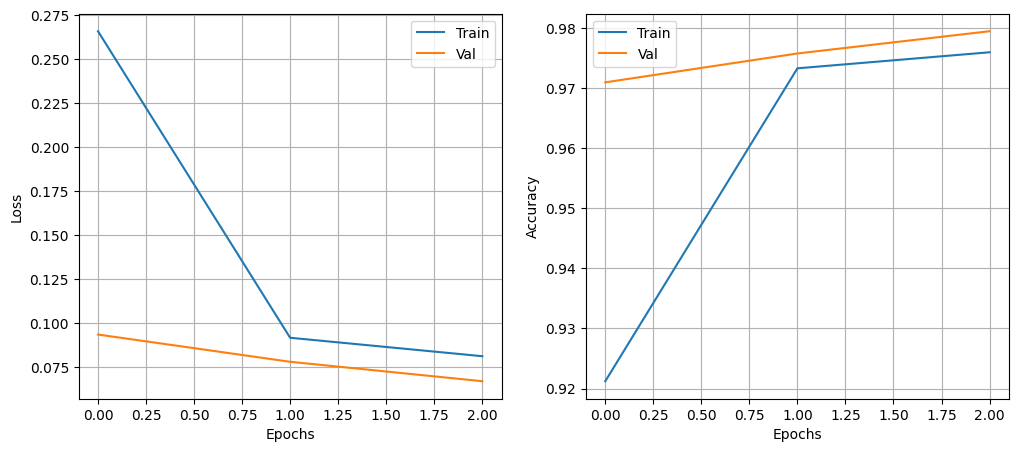

Epoch 4/10
  Train: loss=0.0716 | acc=0.9794
  Val  : loss=0.0582 | acc=0.9807
  Trainable params: 34794
  lr=0.006800


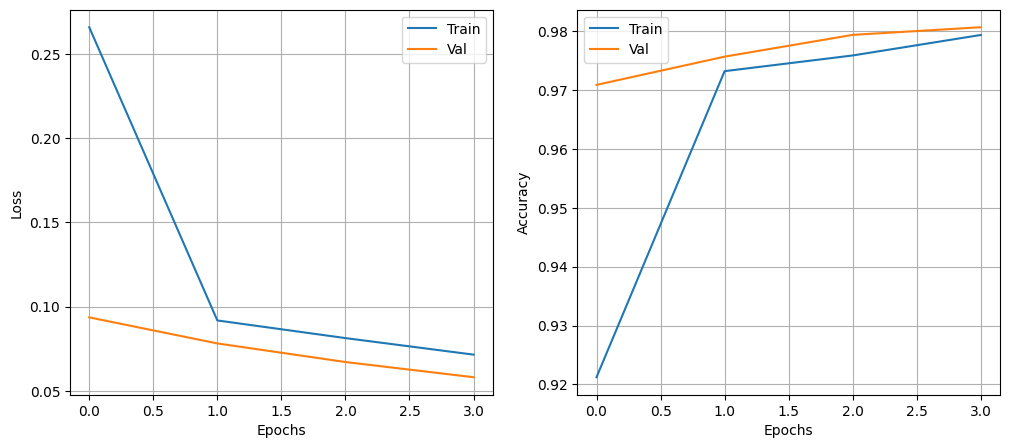

Epoch 5/10
  Train: loss=0.0640 | acc=0.9807
  Val  : loss=0.0527 | acc=0.9829
  Trainable params: 34794
  lr=0.008400


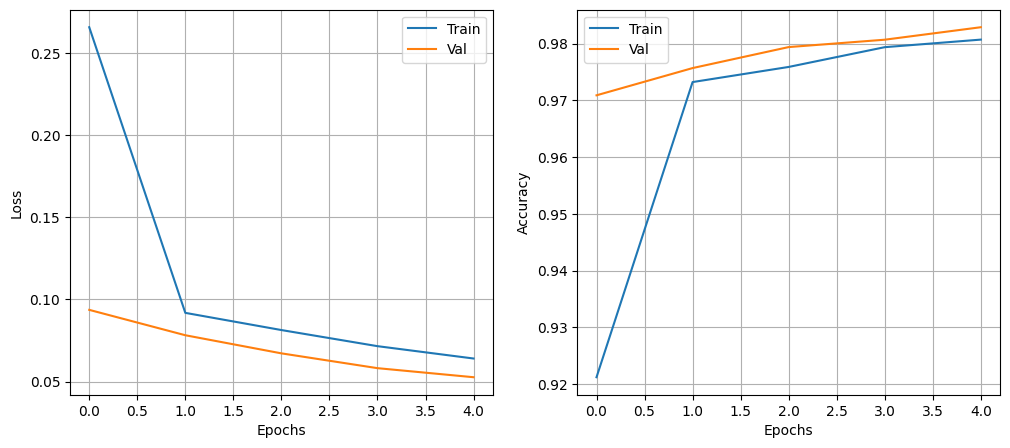

Epoch 6/10
  Train: loss=0.0575 | acc=0.9825
  Val  : loss=0.0490 | acc=0.9840
  Trainable params: 34794
  lr=0.010000


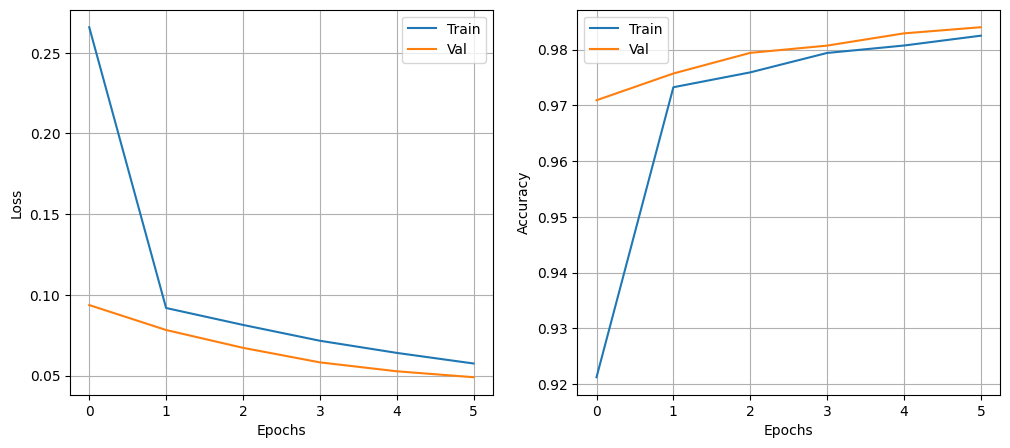

Epoch 7/10
  Train: loss=0.0524 | acc=0.9838
  Val  : loss=0.0554 | acc=0.9830
  Trainable params: 34794
  lr=0.010000


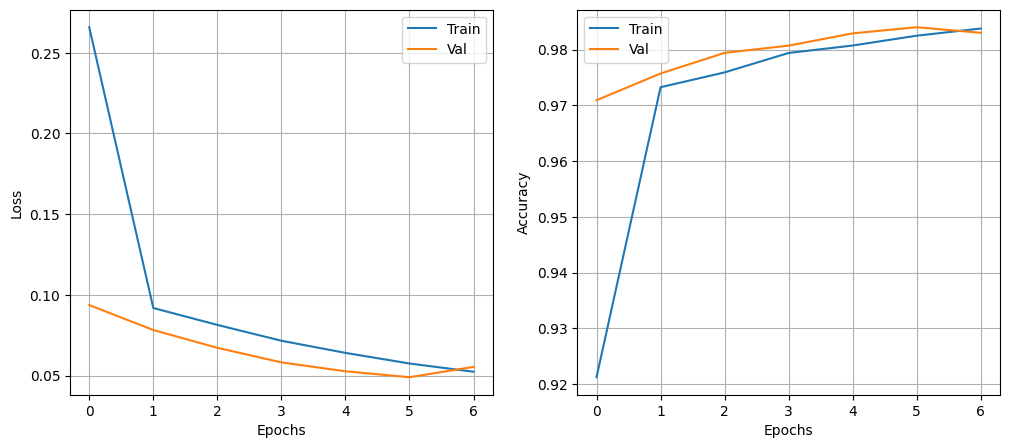

Epoch 8/10
  Train: loss=0.0453 | acc=0.9860
  Val  : loss=0.0418 | acc=0.9859
  Trainable params: 34794
  lr=0.010000


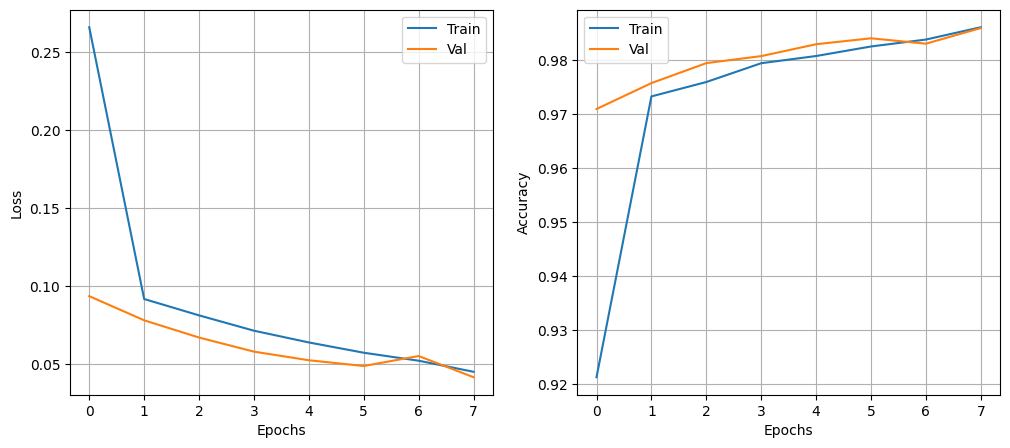

Epoch 9/10
  Train: loss=0.0395 | acc=0.9882
  Val  : loss=0.0405 | acc=0.9869
  Trainable params: 34794
  lr=0.010000


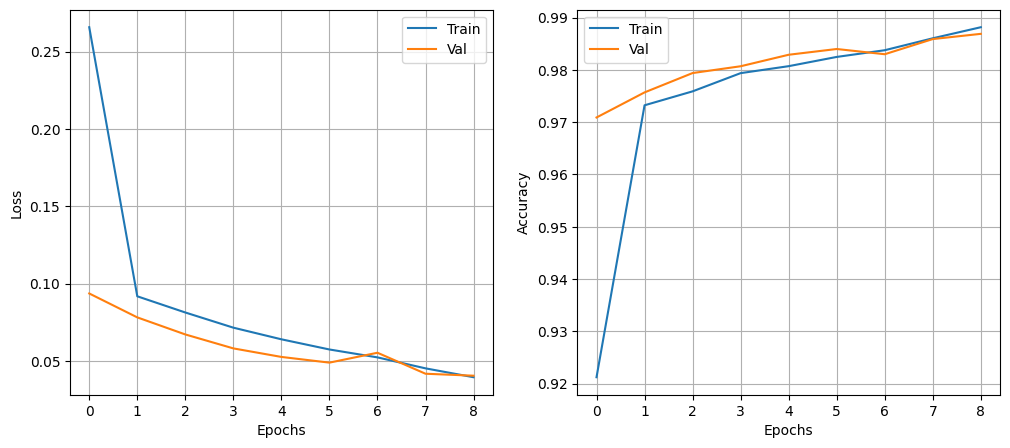

Epoch 10/10
  Train: loss=0.0354 | acc=0.9890
  Val  : loss=0.0360 | acc=0.9881
  Trainable params: 34794
  lr=0.010000


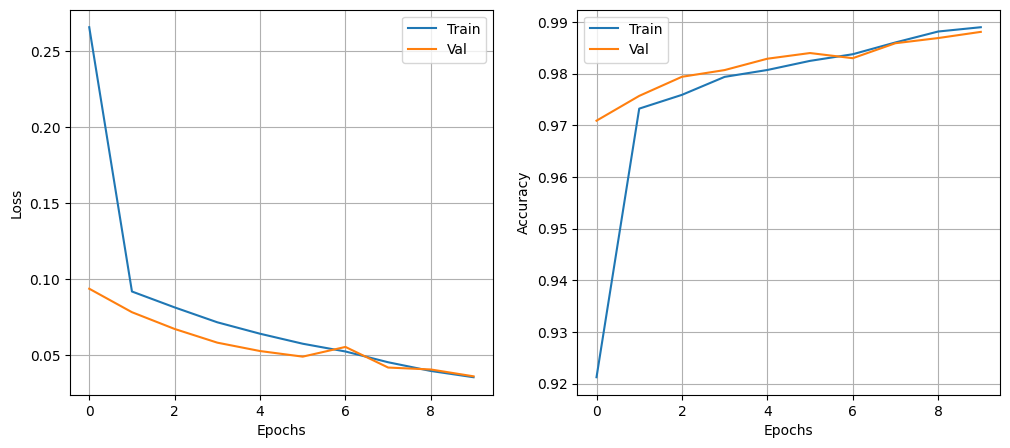

In [35]:
lin_sgd_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       scheduler=scheduler,train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [36]:
model = Net()
optimizer = Adam(params=model.parameters(), b1=0.9, b2=0.99, eta=1e-8, nu=0.005)
scheduler = CosineAnnealing(optimizer, T_max=5, eta_min=1e-5)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.1073 | acc=0.9664
  Val  : loss=0.0469 | acc=0.9854
  Trainable params: 34794
  lr=0.005000


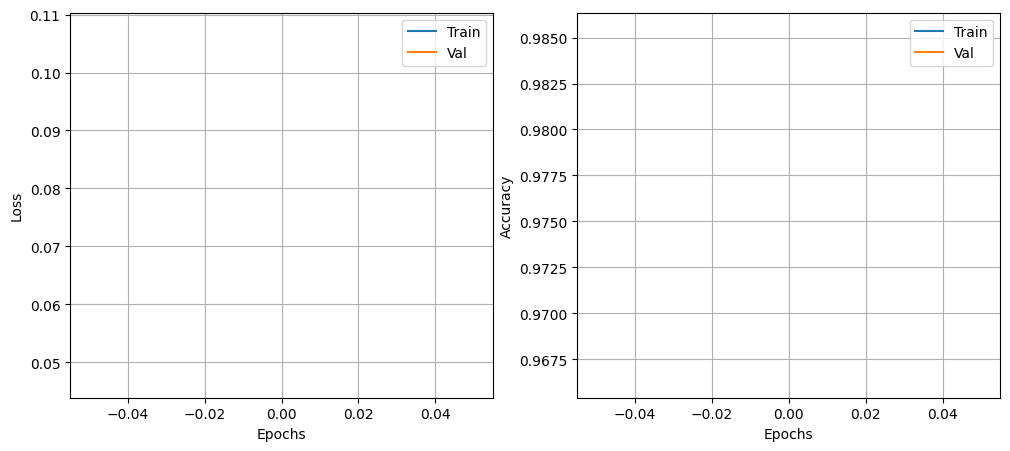

Epoch 2/10
  Train: loss=0.0522 | acc=0.9845
  Val  : loss=0.0457 | acc=0.9856
  Trainable params: 34794
  lr=0.004523


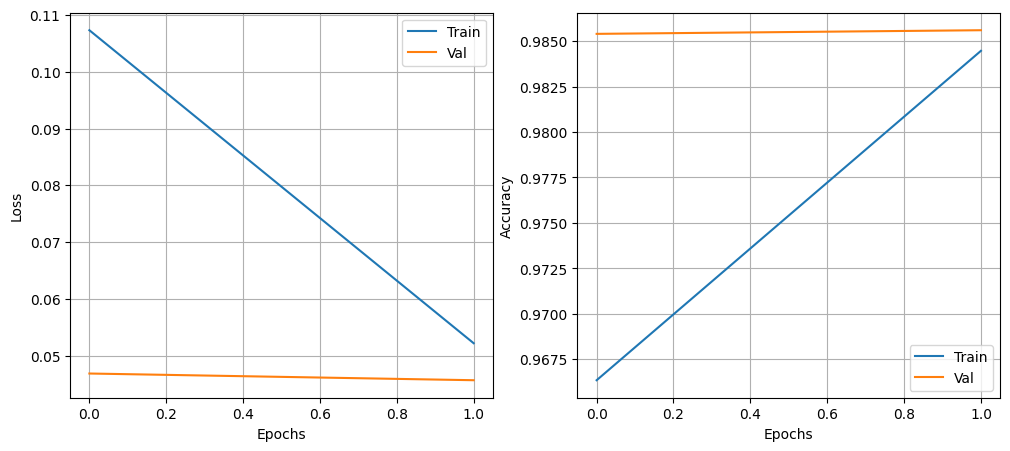

Epoch 3/10
  Train: loss=0.0388 | acc=0.9886
  Val  : loss=0.0442 | acc=0.9854
  Trainable params: 34794
  lr=0.003276


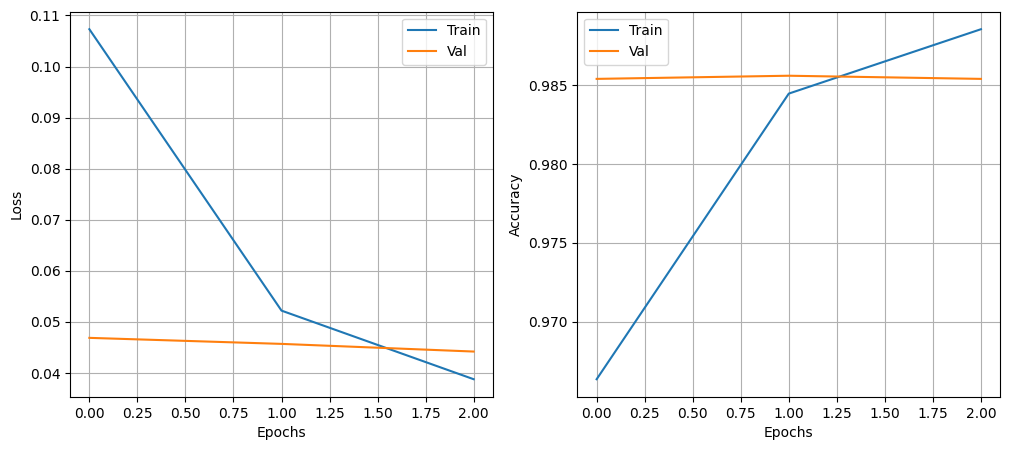

Epoch 4/10
  Train: loss=0.0234 | acc=0.9925
  Val  : loss=0.0385 | acc=0.9885
  Trainable params: 34794
  lr=0.001734


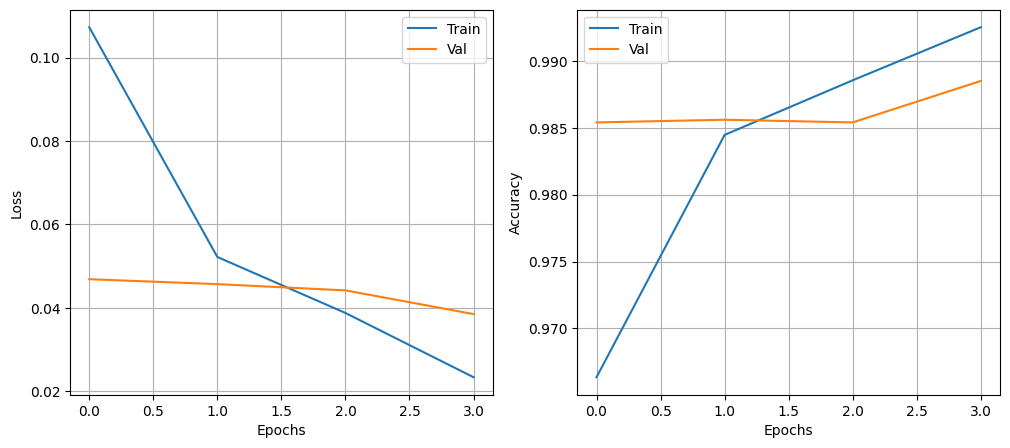

Epoch 5/10
  Train: loss=0.0120 | acc=0.9964
  Val  : loss=0.0409 | acc=0.9906
  Trainable params: 34794
  lr=0.000487


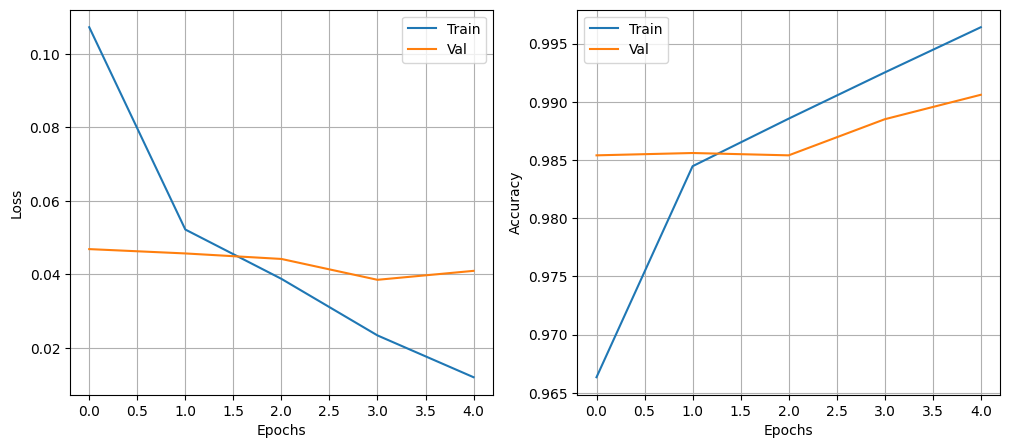

Epoch 6/10
  Train: loss=0.0047 | acc=0.9987
  Val  : loss=0.0384 | acc=0.9914
  Trainable params: 34794
  lr=0.000010


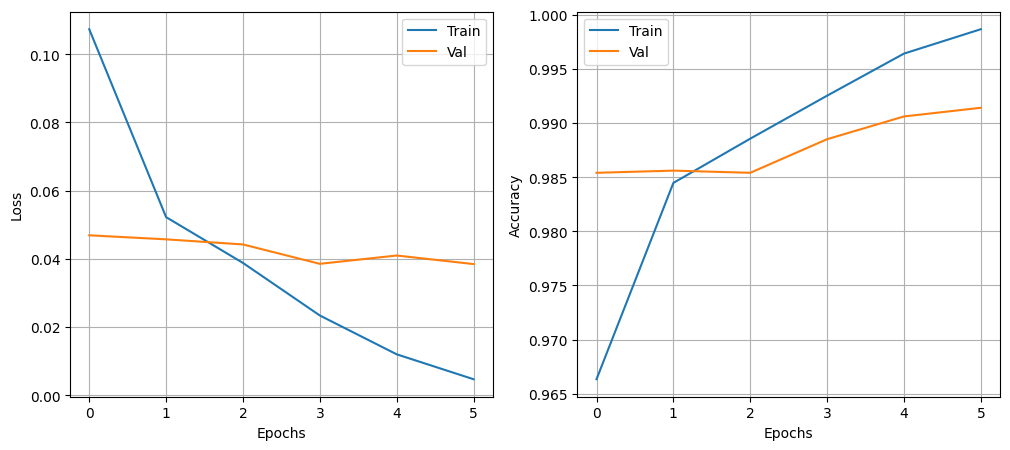

Epoch 7/10
  Train: loss=0.0030 | acc=0.9993
  Val  : loss=0.0381 | acc=0.9917
  Trainable params: 34794
  lr=0.000487


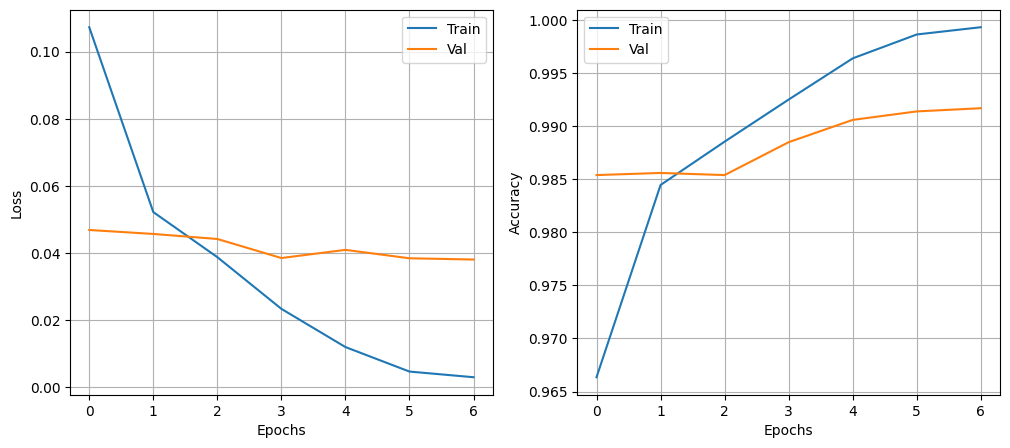

Epoch 8/10
  Train: loss=0.0034 | acc=0.9992
  Val  : loss=0.0387 | acc=0.9919
  Trainable params: 34794
  lr=0.001734


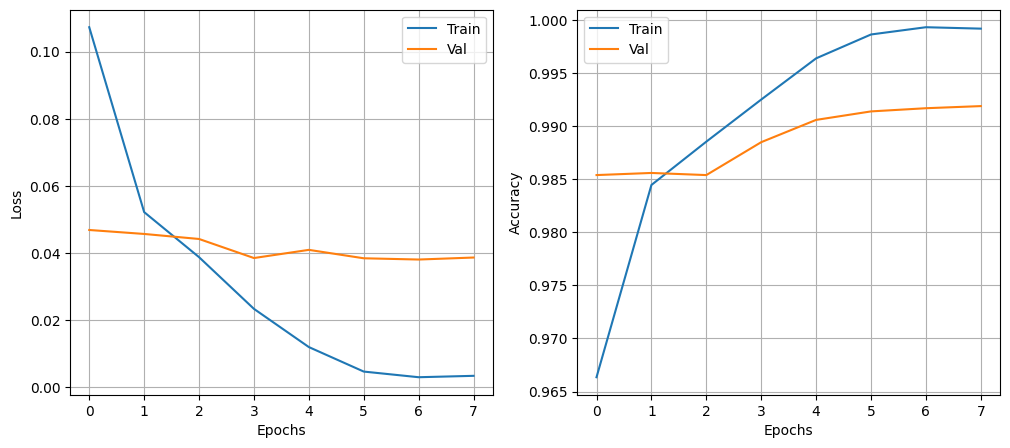

Epoch 9/10
  Train: loss=0.0068 | acc=0.9979
  Val  : loss=0.0457 | acc=0.9908
  Trainable params: 34794
  lr=0.003276


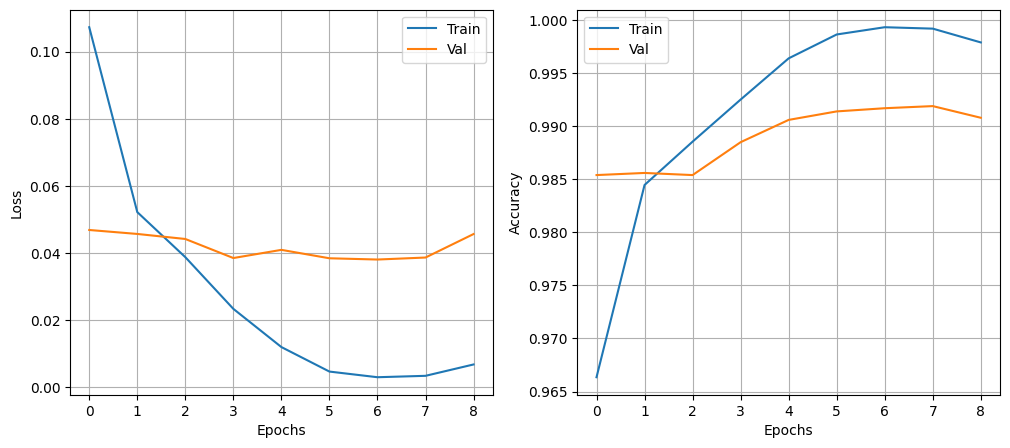

Epoch 10/10
  Train: loss=0.0129 | acc=0.9961
  Val  : loss=0.0572 | acc=0.9873
  Trainable params: 34794
  lr=0.004523


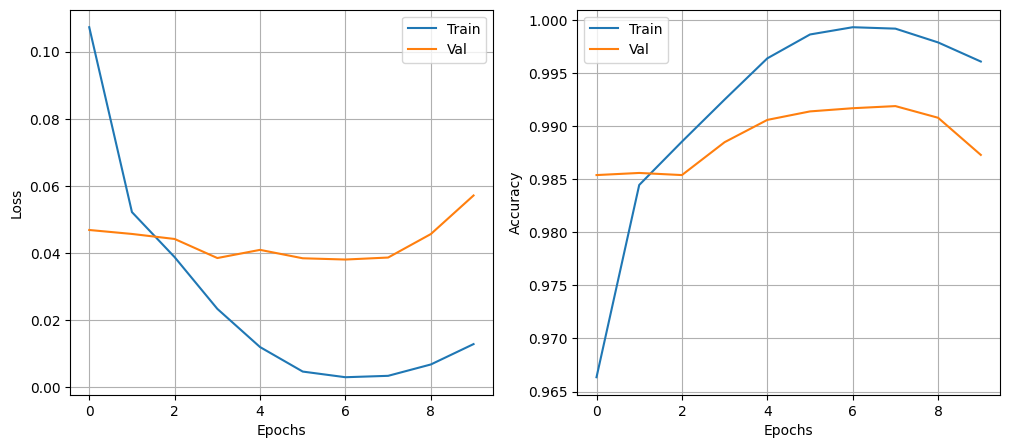

In [37]:
ca_adam_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       scheduler=scheduler,train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [38]:
model = Net()
optimizer = AdamW(params=model.parameters(), b1=0.9, b2=0.999, eta=1e-8, nu=0.005, weight_decay=0.01)
scheduler = CosineAnnealing(optimizer, T_max=5, eta_min=1e-5)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.1258 | acc=0.9614
  Val  : loss=0.0622 | acc=0.9807
  Trainable params: 34794
  lr=0.005000


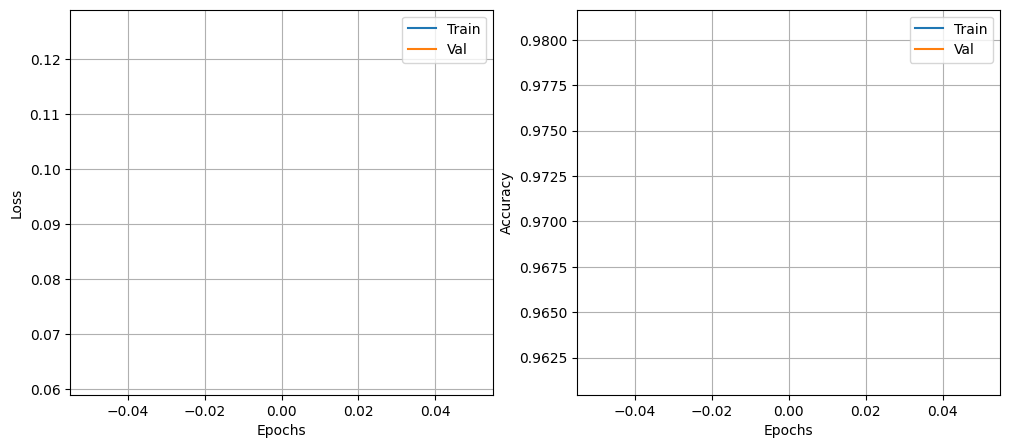

Epoch 2/10
  Train: loss=0.0681 | acc=0.9798
  Val  : loss=0.0528 | acc=0.9829
  Trainable params: 34794
  lr=0.004523


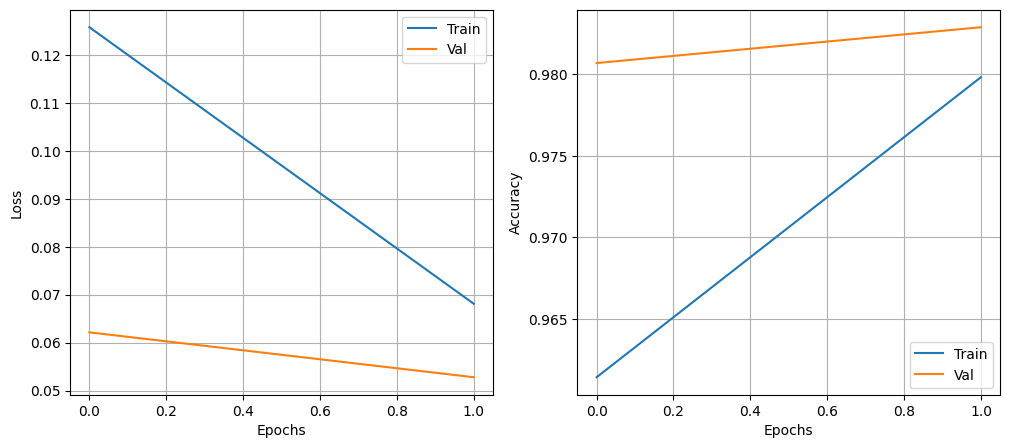

Epoch 3/10
  Train: loss=0.0511 | acc=0.9845
  Val  : loss=0.0447 | acc=0.9869
  Trainable params: 34794
  lr=0.003276


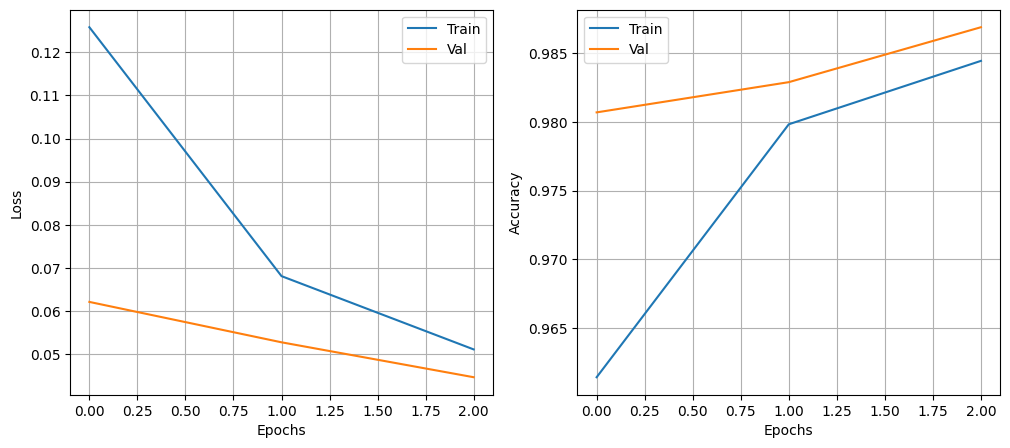

Epoch 4/10
  Train: loss=0.0326 | acc=0.9898
  Val  : loss=0.0511 | acc=0.9852
  Trainable params: 34794
  lr=0.001734


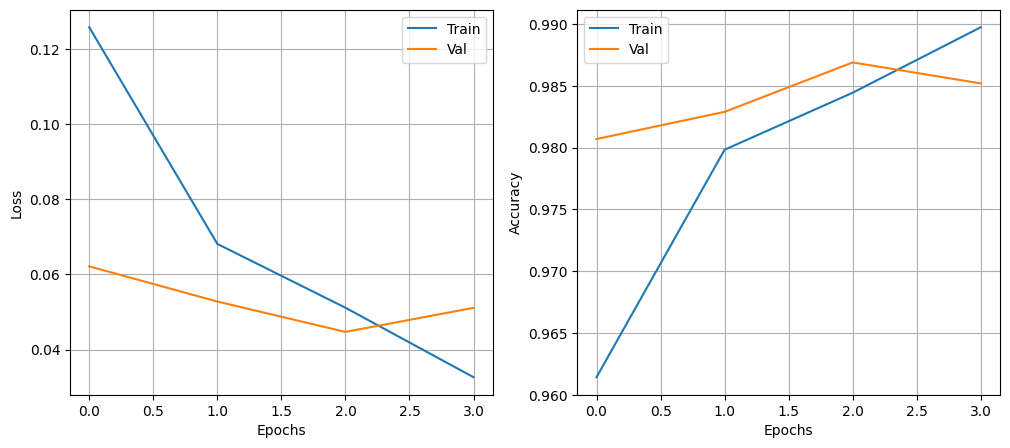

Epoch 5/10
  Train: loss=0.0151 | acc=0.9950
  Val  : loss=0.0421 | acc=0.9885
  Trainable params: 34794
  lr=0.000487


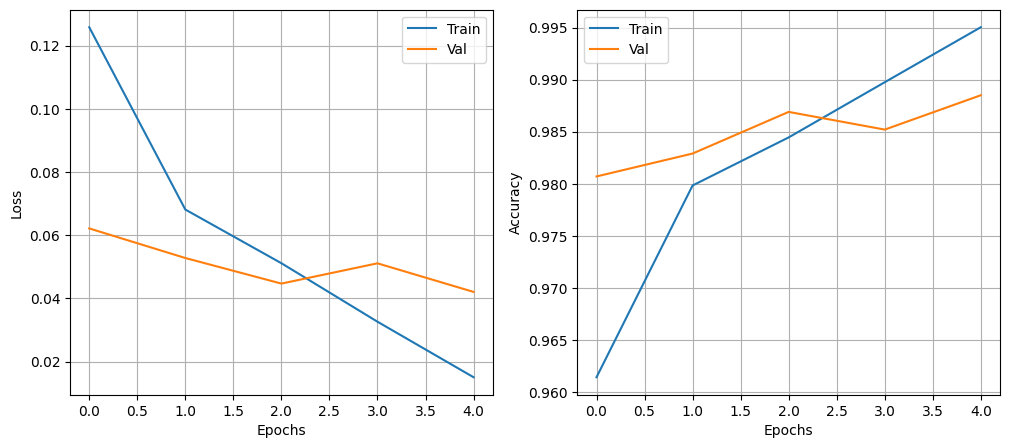

Epoch 6/10
  Train: loss=0.0054 | acc=0.9984
  Val  : loss=0.0395 | acc=0.9899
  Trainable params: 34794
  lr=0.000010


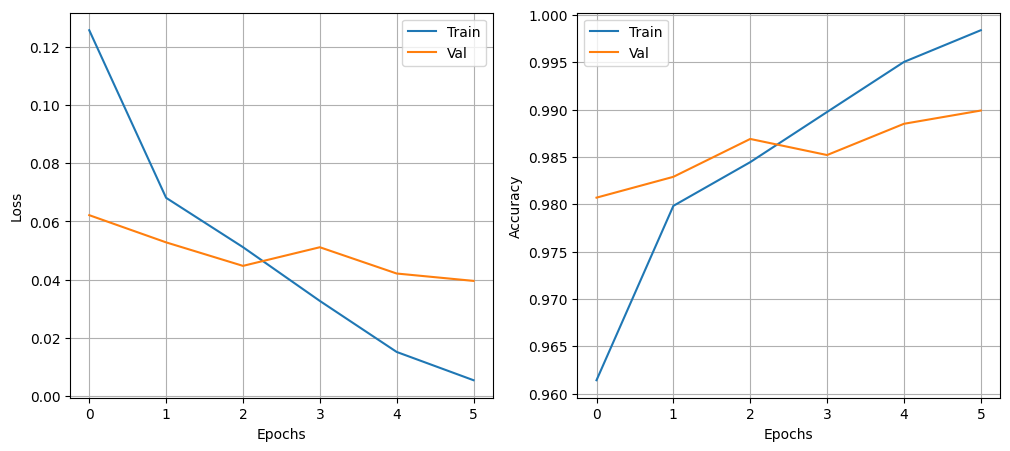

Epoch 7/10
  Train: loss=0.0027 | acc=0.9995
  Val  : loss=0.0377 | acc=0.9902
  Trainable params: 34794
  lr=0.000487


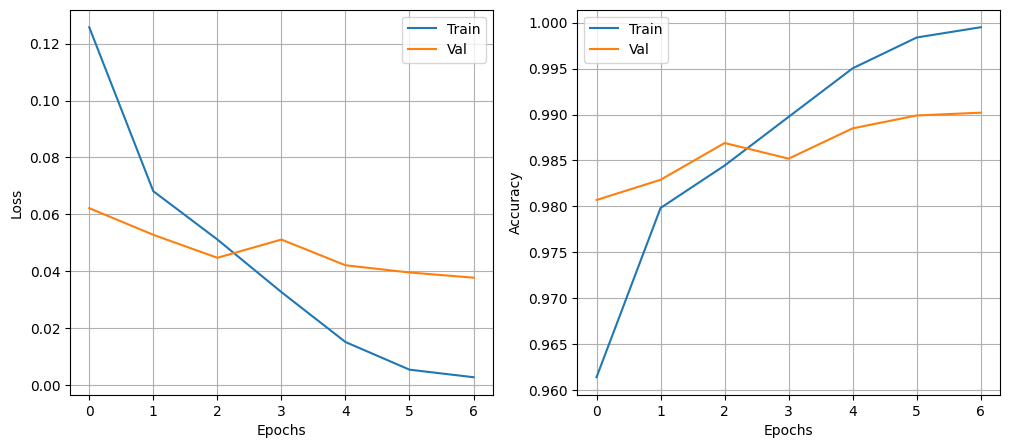

Epoch 8/10
  Train: loss=0.0034 | acc=0.9992
  Val  : loss=0.0383 | acc=0.9899
  Trainable params: 34794
  lr=0.001734


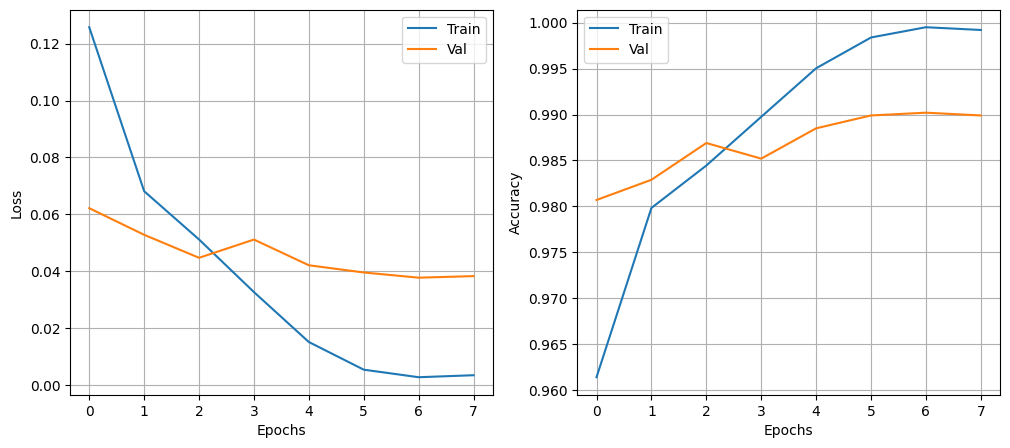

Epoch 9/10
  Train: loss=0.0152 | acc=0.9951
  Val  : loss=0.0470 | acc=0.9888
  Trainable params: 34794
  lr=0.003276


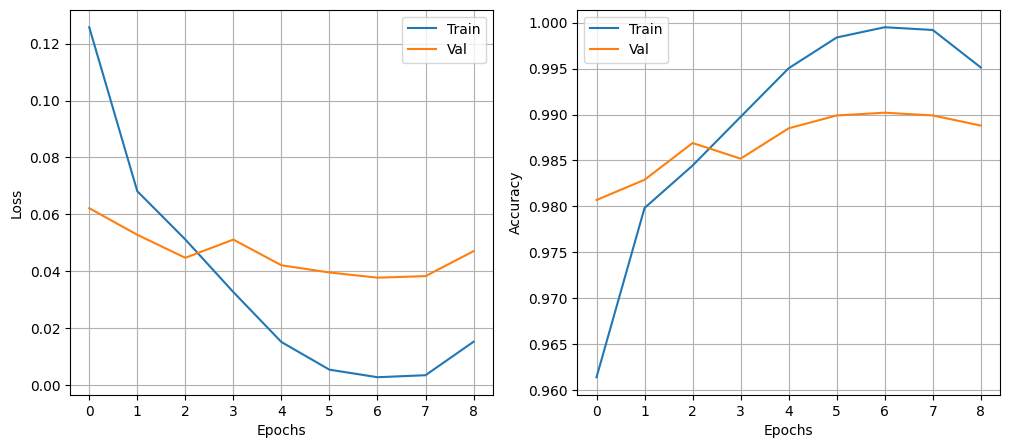

Epoch 10/10
  Train: loss=0.0306 | acc=0.9904
  Val  : loss=0.0504 | acc=0.9874
  Trainable params: 34794
  lr=0.004523


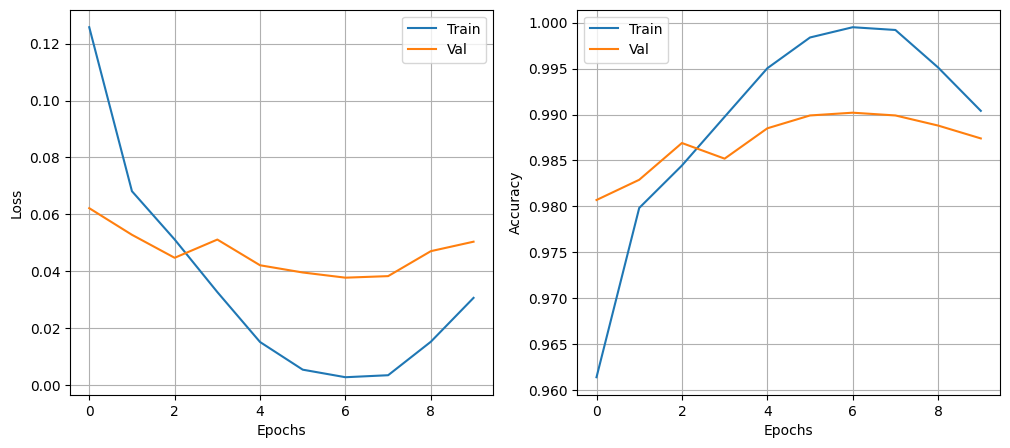

In [39]:
ca_adamw_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       scheduler=scheduler,train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

In [40]:
model = Net()
optimizer = SGD(params=model.parameters())
scheduler = CosineAnnealing(optimizer, T_max=5, eta_min=1e-5)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
  Train: loss=0.2725 | acc=0.9234
  Val  : loss=0.1006 | acc=0.9680
  Trainable params: 34794
  lr=0.010000


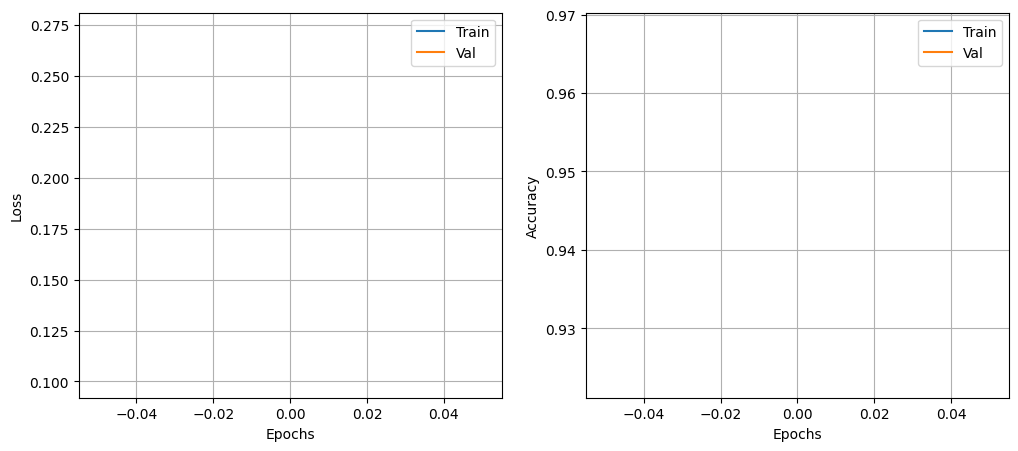

Epoch 2/10
  Train: loss=0.0881 | acc=0.9737
  Val  : loss=0.0653 | acc=0.9806
  Trainable params: 34794
  lr=0.009046


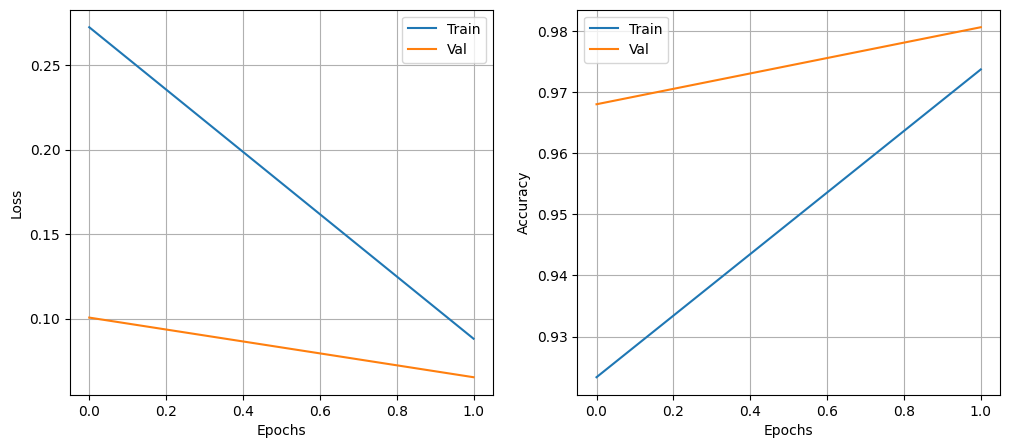

Epoch 3/10
  Train: loss=0.0637 | acc=0.9802
  Val  : loss=0.0495 | acc=0.9839
  Trainable params: 34794
  lr=0.006549


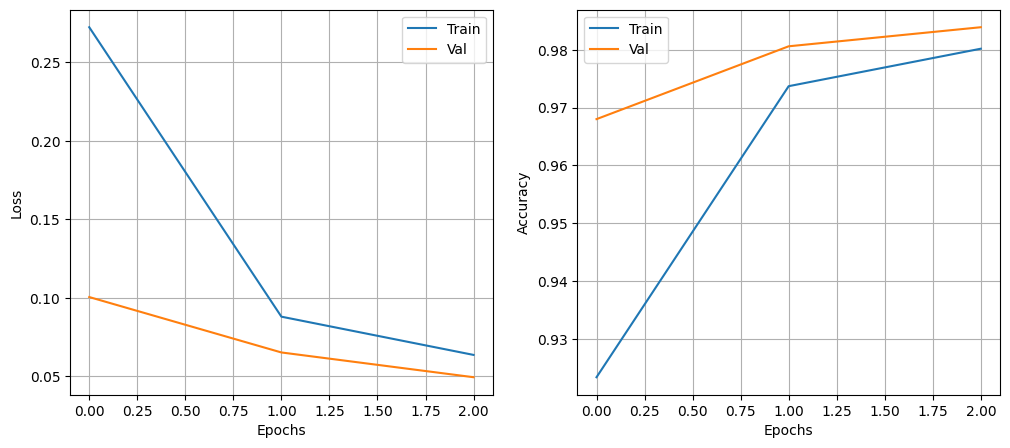

Epoch 4/10
  Train: loss=0.0507 | acc=0.9849
  Val  : loss=0.0421 | acc=0.9859
  Trainable params: 34794
  lr=0.003461


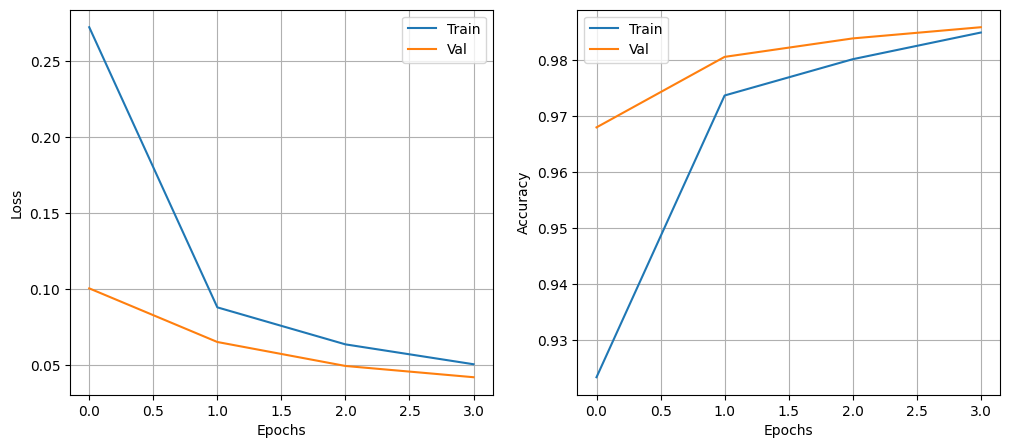

Epoch 5/10
  Train: loss=0.0426 | acc=0.9875
  Val  : loss=0.0401 | acc=0.9877
  Trainable params: 34794
  lr=0.000964


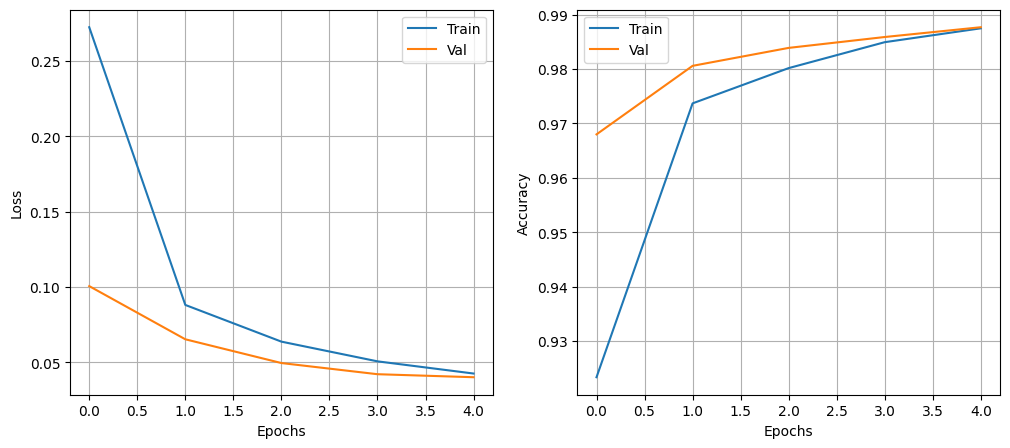

Epoch 6/10
  Train: loss=0.0376 | acc=0.9891
  Val  : loss=0.0374 | acc=0.9882
  Trainable params: 34794
  lr=0.000010


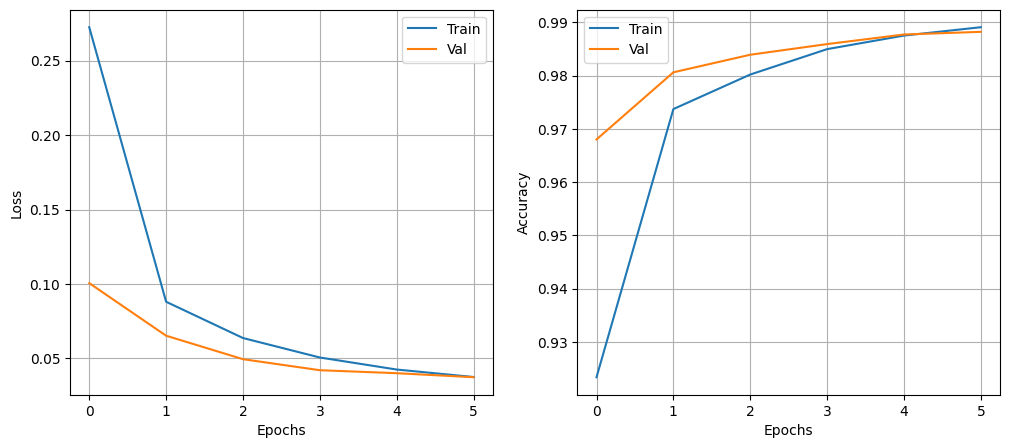

Epoch 7/10
  Train: loss=0.0363 | acc=0.9892
  Val  : loss=0.0372 | acc=0.9882
  Trainable params: 34794
  lr=0.000964


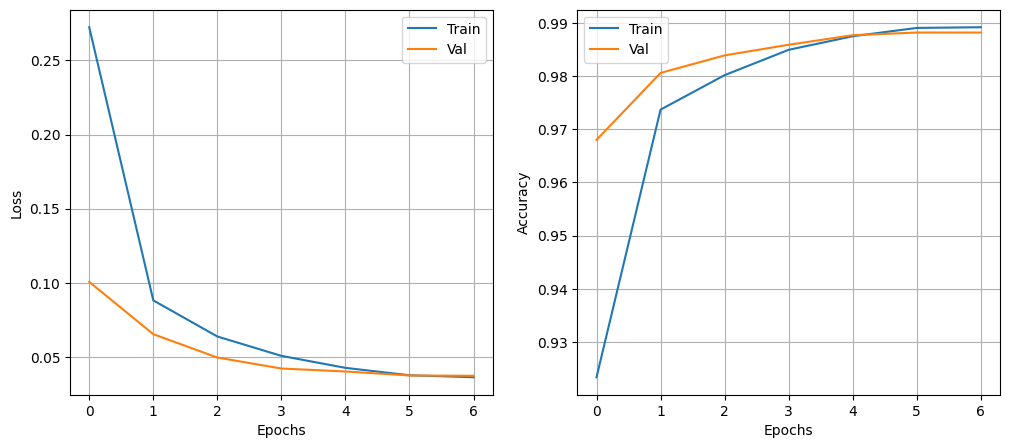

Epoch 8/10
  Train: loss=0.0367 | acc=0.9893
  Val  : loss=0.0372 | acc=0.9883
  Trainable params: 34794
  lr=0.003461


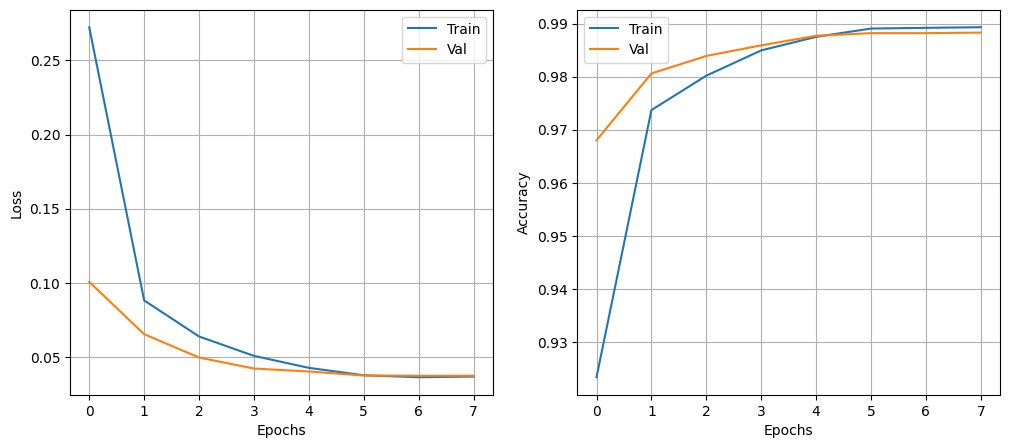

Epoch 9/10
  Train: loss=0.0385 | acc=0.9882
  Val  : loss=0.0393 | acc=0.9879
  Trainable params: 34794
  lr=0.006549


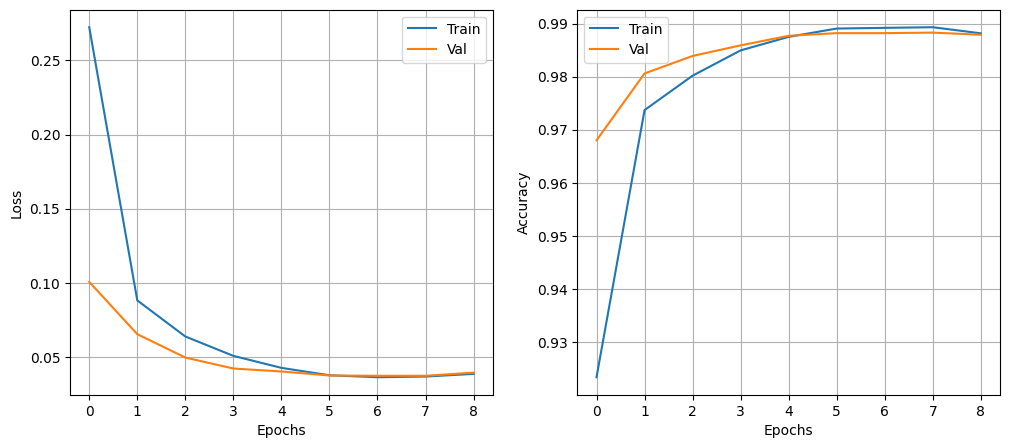

Epoch 10/10
  Train: loss=0.0396 | acc=0.9880
  Val  : loss=0.0404 | acc=0.9865
  Trainable params: 34794
  lr=0.009046


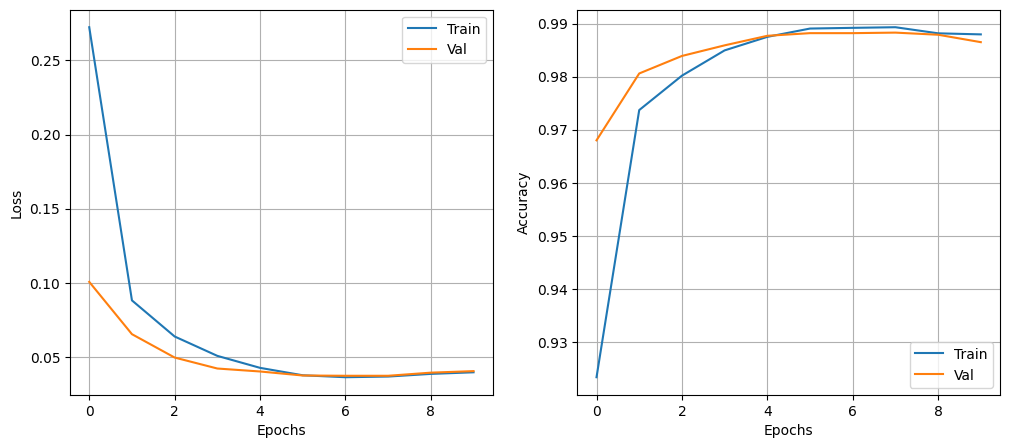

In [41]:
ca_sgd_hist = train(net=model, optimizer=optimizer, epochs=10, criterion=nn.NLLLoss(),
       scheduler=scheduler,train_loader=train_loader, val_loader=test_loader, plot=True, verbose=True)

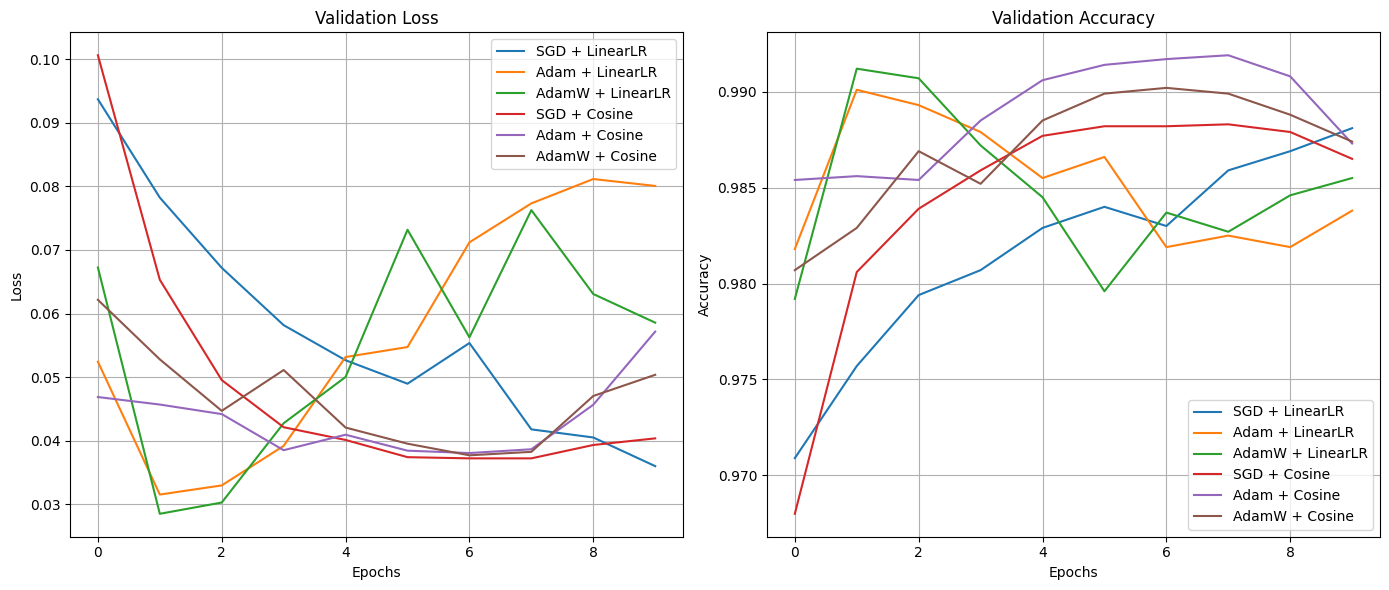

In [42]:
histories = {
    "SGD + LinearLR":   lin_sgd_hist,
    "Adam + LinearLR":  lin_adam_hist,
    "AdamW + LinearLR": lin_adamw_hist,
    "SGD + Cosine":     ca_sgd_hist,
    "Adam + Cosine":    ca_adam_hist,
    "AdamW + Cosine":   ca_adamw_hist,
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for name, h in histories.items():
    ax1.plot(h["val_loss"], label=name)
    ax2.plot(h["val_acc"],  label=name)

ax1.set_title("Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

Использование scheduler’ов улучшает качество обучения для всех методов. LinearLR помогает ускорить сходимость на начальных этапах, но при длительном обучении может вызывать нестабильность из-за роста learning rate. В то время как CosineAnnealingLR обеспечивает плавное снижение скорости обучения и более стабильное поведение модели.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here